In [58]:
from deepface import DeepFace
import pandas as pd
import os
from tqdm import tqdm
def get_emotion(image_path):
    try:
        result = DeepFace.analyze(img_path=image_path, actions=['emotion'], enforce_detection=False)
        if 'emotion' in result[0]:
            emotion_info = result[0]['emotion']
            dominant_emotion = max(emotion_info, key=emotion_info.get)  # Get the dominant emotion
            dominant_emotion_score = emotion_info[dominant_emotion]  # Get the numerical score
            return dominant_emotion, dominant_emotion_score
        else:
            print(f"No emotion information found for {image_path}")
            return None, None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

folder_path = "AgeDB/AgeDB/"
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

data = []
for image_file in tqdm(image_files):
    image_path = os.path.join(folder_path, image_file)
    emotion, emotion_score = get_emotion(image_path)
    if emotion is not None:
        df = pd.DataFrame({'image_name': [image_file], 'emotion': [emotion], 'emotion_score': [emotion_score]})
        df.to_csv('emotions_val.csv', mode='a', header=False, index=False)


AttributeError: module 'tensorflow' has no attribute '__version__'

In [7]:
df= pd.read_csv('emotions.csv')
df

image_name emotion
0         0_MariaCallas_35_f.jpg     sad
1      10000_GlennClose_62_f.jpg   happy
2      10001_GoldieHawn_23_f.jpg   happy
3      10002_GoldieHawn_24_f.jpg   happy
4      10003_GoldieHawn_24_f.jpg   happy
...                          ...     ...
16483   9998_GlennClose_59_f.jpg   happy
16484   9999_GlennClose_61_f.jpg   happy
16485     999_CarlSagan_35_m.jpg   happy
16486       99_PaulAnka_46_m.jpg   happy
16487     9_MariaCallas_30_f.jpg    fear

[16488 rows x 2 columns]

In [4]:
df.sad.value_counts()

neutral     5390
happy       5289
sad         2447
fear        1624
angry       1265
surprise     252
disgust       89
Name: sad, dtype: int64

In [5]:
import re

def extract_age_from_filename(filename):
    age = re.search(r'_(\d+)_', filename)
    if age:
        return int(age.group(1))
    else:
        return None

In [8]:
df['age'] = df['image_name'].apply(extract_age_from_filename)

In [15]:
df.age.value_counts()

35     413
40     386
30     385
38     382
32     378
      ... 
96       2
99       1
97       1
1        1
101      1
Name: age, Length: 100, dtype: int64

In [16]:
df.to_csv('emotions.csv', index=False)

In [21]:
def extract_person_name(filename):
    # Extract the person's name from the filename using a regular expression
    match = re.search(r'(\d+)_([\w]+)_(\d+)', filename)
    if match:
        return match.group(2)
    else:
        return None

def group_by_person(folder_path):
    # List all the filenames in the folder
    filenames = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Group filenames by person's name
    grouped = {}
    for filename in filenames:
        person_name = extract_person_name(filename)
        if person_name not in grouped:
            grouped[person_name] = []
        grouped[person_name].append(filename)
    
    # Sort filenames within each person group
    for person_name, files in grouped.items():
        grouped[person_name] = sorted(files)
    
    return grouped

def write_to_file(grouped, output_file):
    with open(output_file, 'w') as f:
        for person_name, filenames in grouped.items():
            for i in range(len(filenames)):
                for j in range(i+1, len(filenames)):
                    f.write(f"{filenames[i]} {filenames[j]}\n")


In [22]:
folder_path = "AgeDB/AgeDB/"  # Change this to your folder path
output_file = './AgeDB_pairs.txt'  # Change this if you want a different output filename

# Load the CSV into a DataFrame
# df = pd.read_csv('emotions.csv')

grouped = group_by_person(folder_path)
write_to_file(grouped, output_file)

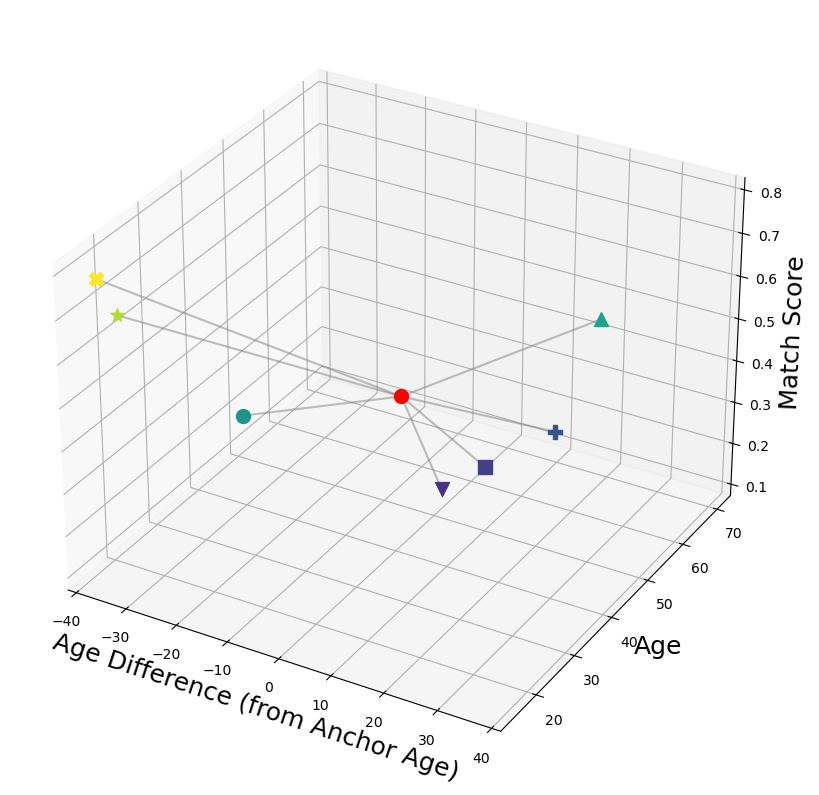

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.mplot3d import Axes3D, art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Define fancy markers
fancy_markers = ['o', 'X', 'P', '*', 's', 'D', 'v', '^']

# Provided data for the subnetwork, with the anchor image being the one with an age difference of 0
provided_data = [
    (0.40, 30, -22),
    (0.78, 15, -37),
    (0.20, 65, 13),
    (0.69, 17, -35),
    (0.15, 57, 5),
    (0.36, 48, -5),
    (0.12, 52, 0),  # Anchor image
    (0.45, 70, 18)
]

# Extract the anchor data
anchor_data = provided_data[-3]  # Adjust the index if the anchor image is not the third last

# Convert match scores to a NumPy array for element-wise operations
match_scores_array = np.array([data[0] for data in provided_data])

# Define a gradient color map based on match scores
colors = plt.cm.viridis(match_scores_array / max(match_scores_array))

# Set up the 3D plot with the title "Latent Representation of Age Difference with Match Scores"
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the anchor marker using the anchor data
ax.scatter(anchor_data[2], anchor_data[1], anchor_data[0], c='red', s=100, depthshade=True, label="Anchor Image")

# Plot the images and connect them to the anchor image with gradient colors and fancy markers
for i, (match_score, age, age_difference) in enumerate(provided_data):
    # Exclude the anchor image from connections
    if i == provided_data.index(anchor_data):  # Check if it's the anchor image
        continue
    # Choose a fancy marker shape
    marker_shape = fancy_markers[i % len(fancy_markers)]
    # Plot the image marker with gradient color
    ax.scatter(age_difference, age, match_score, marker=marker_shape, s=100, color=colors[i], depthshade=True, label=f"Image {i+1}")
    # Draw the connecting line
    ax.plot([anchor_data[2], age_difference], [anchor_data[1], age], [anchor_data[0], match_score], color='grey', alpha=0.5)
    # Calculate mid-point for annotation
    mid_point = [(anchor_data[2] + age_difference) / 2, (anchor_data[1] + age) / 2, (anchor_data[0] + match_score) / 2]
    # Annotate the tuple
    # tuple_text = f"({match_score:.2f}, {age}, {age_difference})"
    # ax.text(mid_point[0], mid_point[1], mid_point[2], tuple_text, color='black')

# Set labels for axes
ax.set_xlabel('Age Difference (from Anchor Age)', fontsize=18)
ax.set_ylabel('Age' , fontsize=18)
ax.set_zlabel('Match Score', fontsize=18)

# Set the x-axis limit to show a symmetric scale around the anchor age difference
ax.set_xlim(-40, 40)

# Title
# plt.title('Latent Representation of Age Difference with Match Scores', fontsize=18)

# Set legend with fancy markers
# legend = ax.legend(loc='upper left', fontsize=12, bbox_to_anchor=(-.05, 1))
# for i, text in enumerate(legend.get_texts()):
#     # Adjust legend text color to match the marker color, excluding the anchor image
#     if i < len(colors) - 1:
#         text.set_color(colors[i])
        

plt.savefig('latent_representation.jpg', bbox_inches='tight')
# Show the plot
plt.show()


c:\Users\VIDEOKYC\.conda\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py:3194: DtypeWarning: Columns (2,5,6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\VIDEOKYC\AppData\Local\Temp\ipykernel_17992\2366902321.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emotion_match['VGG-Face'] = pd.to_numeric(df_emotion_match['VGG-Face'], errors='coerce')


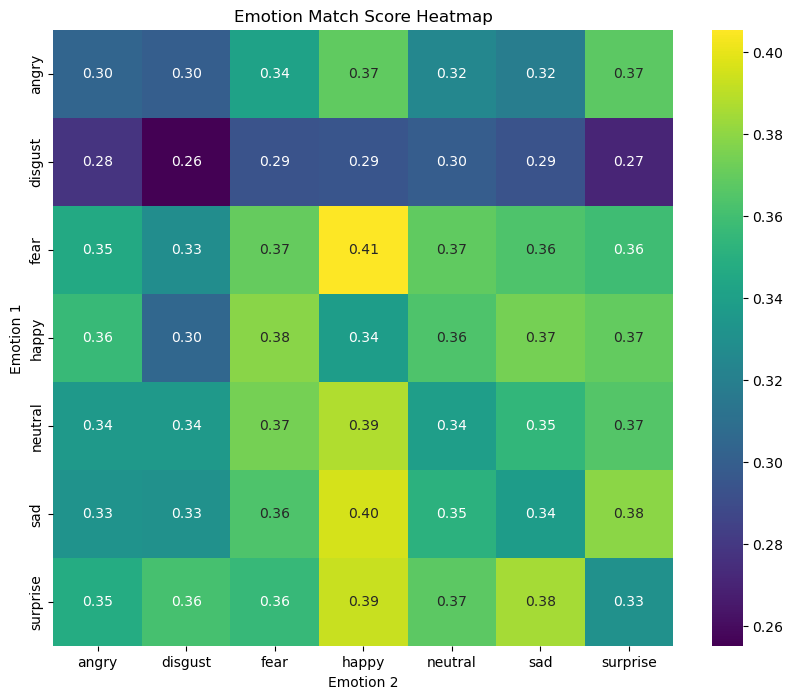

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to your CSV file
file_path = 'AEM_scores.csv'

# Load the CSV file with the provided column names
df = pd.read_csv(file_path)

# Select only the columns we're interested in for the emotion comparison
df_emotion_match = df[['Image1 Emotion', 'Image2 Emotion', 'VGG-Face']]

# Convert 'VGG-Face Match' to numeric, forcing non-convertible values to NaN
df_emotion_match['VGG-Face'] = pd.to_numeric(df_emotion_match['VGG-Face'], errors='coerce')

# Drop rows with NaN values in 'VGG-Face Match' column
df_emotion_match = df_emotion_match.dropna(subset=['VGG-Face'])

# Group the data by emotion pairs
emotion_pairs = df_emotion_match.groupby(['Image1 Emotion', 'Image2 Emotion'])

# Initialize an empty list to store the match scores
emotion_match_scores = []

# Loop through the emotion pairs and sample
for name, group in emotion_pairs:
    # Sample 50 from each group, if there are at least 50, otherwise take what's available
    samples = group.sample(n=50000, replace=True) if len(group) >= 50 else group
    for _, row in samples.iterrows():
        emotion_match_scores.append((name[0], name[1], row['VGG-Face']))

# Now you have a list of tuples with emotion pairs and match scores
# print(emotion_match_scores[:10])

# Convert the list of tuples into a DataFrame
df = pd.DataFrame(emotion_match_scores, columns=['Emotion1', 'Emotion2', 'MatchScore'])

# Create a pivot table with mean match scores for each emotion pair
pivot_table = df.pivot_table(index='Emotion1', columns='Emotion2', values='MatchScore', aggfunc='mean')

# Create the heatmap using seaborn
plt.figure(figsize=(10, 8))  # You can adjust the size as needed
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='viridis')

# Set the titles and labels
plt.title('Emotion Match Score Heatmap')
plt.xlabel('Emotion 2')
plt.ylabel('Emotion 1')

# Show the heatmap
plt.show()


c:\Users\VIDEOKYC\.conda\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py:3194: DtypeWarning: Columns (2,5,6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\VIDEOKYC\AppData\Local\Temp\ipykernel_17992\2168734864.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emotion_match['OpenFace'] = pd.to_numeric(df_emotion_match['OpenFace'], errors='coerce')


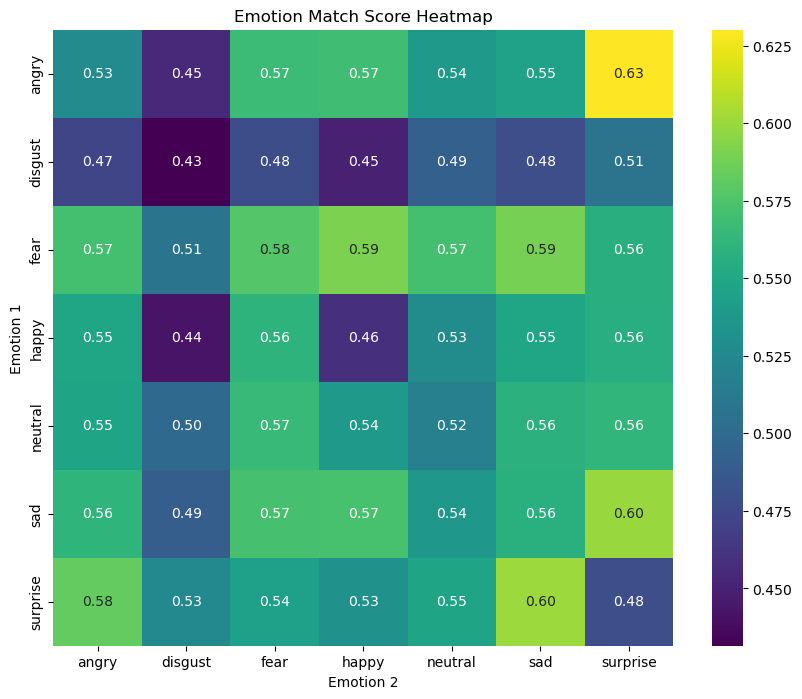

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to your CSV file
file_path = 'AEM_scores.csv'

# Load the CSV file with the provided column names
df = pd.read_csv(file_path)

# Select only the columns we're interested in for the emotion comparison
df_emotion_match = df[['Image1 Emotion', 'Image2 Emotion', 'OpenFace']]

# Convert 'VGG-Face Match' to numeric, forcing non-convertible values to NaN
df_emotion_match['OpenFace'] = pd.to_numeric(df_emotion_match['OpenFace'], errors='coerce')

# Drop rows with NaN values in 'VGG-Face Match' column
df_emotion_match = df_emotion_match.dropna(subset=['OpenFace'])

# Group the data by emotion pairs
emotion_pairs = df_emotion_match.groupby(['Image1 Emotion', 'Image2 Emotion'])

# Initialize an empty list to store the match scores
emotion_match_scores = []

# Loop through the emotion pairs and sample
for name, group in emotion_pairs:
    # Sample 50 from each group, if there are at least 50, otherwise take what's available
    samples = group.sample(n=1000, replace=True) if len(group) >= 50 else group
    for _, row in samples.iterrows():
        emotion_match_scores.append((name[0], name[1], row['OpenFace']))

# Now you have a list of tuples with emotion pairs and match scores
# print(emotion_match_scores[:10])

# Convert the list of tuples into a DataFrame
df = pd.DataFrame(emotion_match_scores, columns=['Emotion1', 'Emotion2', 'MatchScore'])

# Create a pivot table with mean match scores for each emotion pair
pivot_table = df.pivot_table(index='Emotion1', columns='Emotion2', values='MatchScore', aggfunc='mean')

# Create the heatmap using seaborn
plt.figure(figsize=(10, 8))  # You can adjust the size as needed
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='viridis')

# Set the titles and labels
plt.title('Emotion Match Score Heatmap')
plt.xlabel('Emotion 2')
plt.ylabel('Emotion 1')

# Show the heatmap
plt.show()


c:\Users\VIDEOKYC\.conda\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py:3194: DtypeWarning: Columns (2,5,6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\VIDEOKYC\AppData\Local\Temp\ipykernel_17992\220286878.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emotion_match['Facenet'] = pd.to_numeric(df_emotion_match['Facenet'], errors='coerce')


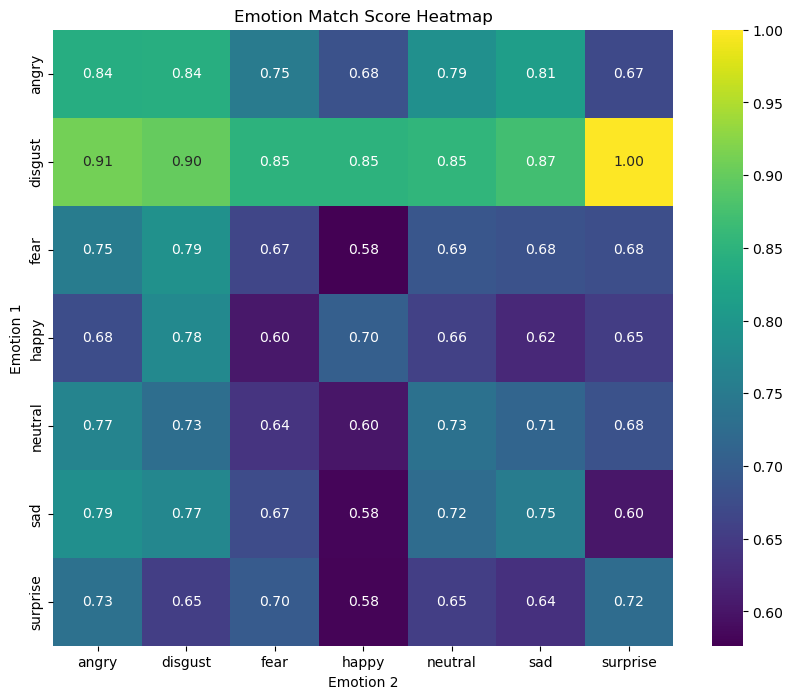

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to your CSV file
file_path = 'AEM_scores.csv'

# Load the CSV file with the provided column names
df = pd.read_csv(file_path)

# Select only the columns we're interested in for the emotion comparison
df_emotion_match = df[['Image1 Emotion', 'Image2 Emotion', 'Facenet']]

# Convert 'VGG-Face Match' to numeric, forcing non-convertible values to NaN
df_emotion_match['Facenet'] = pd.to_numeric(df_emotion_match['Facenet'], errors='coerce')

# Drop rows with NaN values in 'VGG-Face Match' column
df_emotion_match = df_emotion_match.dropna(subset=['Facenet'])

# Group the data by emotion pairs
emotion_pairs = df_emotion_match.groupby(['Image1 Emotion', 'Image2 Emotion'])

# Initialize an empty list to store the match scores
emotion_match_scores = []

# Loop through the emotion pairs and sample
for name, group in emotion_pairs:
    # Sample 50 from each group, if there are at least 50, otherwise take what's available
    samples = group.sample(n=5000, replace=True) if len(group) >= 50 else group
    for _, row in samples.iterrows():
        emotion_match_scores.append((name[0], name[1], row['Facenet']))

# Now you have a list of tuples with emotion pairs and match scores
# print(emotion_match_scores[:10])

# Convert the list of tuples into a DataFrame
df = pd.DataFrame(emotion_match_scores, columns=['Emotion1', 'Emotion2', 'MatchScore'])

# Create a pivot table with mean match scores for each emotion pair
pivot_table = df.pivot_table(index='Emotion1', columns='Emotion2', values='MatchScore', aggfunc='mean')

# Create the heatmap using seaborn
plt.figure(figsize=(10, 8))  # You can adjust the size as needed
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='viridis')

# Set the titles and labels
plt.title('Emotion Match Score Heatmap')
plt.xlabel('Emotion 2')
plt.ylabel('Emotion 1')

# Show the heatmap
plt.show()


c:\Users\VIDEOKYC\.conda\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py:3194: DtypeWarning: Columns (2,5,6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\VIDEOKYC\AppData\Local\Temp\ipykernel_17992\697635822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emotion_match['ArcFace'] = pd.to_numeric(df_emotion_match['ArcFace'], errors='coerce')


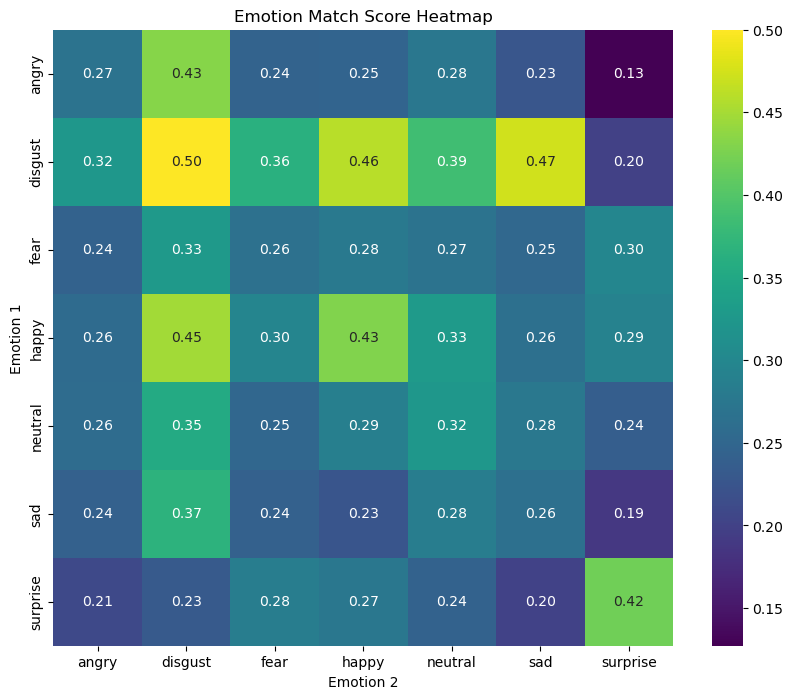

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to your CSV file
file_path = 'AEM_scores.csv'

# Load the CSV file with the provided column names
df = pd.read_csv(file_path)

# Select only the columns we're interested in for the emotion comparison
df_emotion_match = df[['Image1 Emotion', 'Image2 Emotion', 'ArcFace']]

# Convert 'VGG-Face Match' to numeric, forcing non-convertible values to NaN
df_emotion_match['ArcFace'] = pd.to_numeric(df_emotion_match['ArcFace'], errors='coerce')

# Drop rows with NaN values in 'VGG-Face Match' column
df_emotion_match = df_emotion_match.dropna(subset=['ArcFace'])

# Group the data by emotion pairs
emotion_pairs = df_emotion_match.groupby(['Image1 Emotion', 'Image2 Emotion'])

# Initialize an empty list to store the match scores
emotion_match_scores = []

# Loop through the emotion pairs and sample
for name, group in emotion_pairs:
    # Sample 50 from each group, if there are at least 50, otherwise take what's available
    samples = group.sample(n=5000, replace=True) if len(group) >= 50 else group
    for _, row in samples.iterrows():
        emotion_match_scores.append((name[0], name[1], row['ArcFace']))

# Now you have a list of tuples with emotion pairs and match scores
# print(emotion_match_scores[:10])

# Convert the list of tuples into a DataFrame
df = pd.DataFrame(emotion_match_scores, columns=['Emotion1', 'Emotion2', 'MatchScore'])

# Create a pivot table with mean match scores for each emotion pair
pivot_table = df.pivot_table(index='Emotion1', columns='Emotion2', values='MatchScore', aggfunc='mean')

# Create the heatmap using seaborn
plt.figure(figsize=(10, 8))  # You can adjust the size as needed
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='viridis')

# Set the titles and labels
plt.title('Emotion Match Score Heatmap')
plt.xlabel('Emotion 2')
plt.ylabel('Emotion 1')

# Show the heatmap
plt.show()


# Age Difference including Face Expression

c:\Users\VIDEOKYC\.conda\envs\gpu\lib\site-packages\IPython\core\interactiveshell.py:3194: DtypeWarning: Columns (2,5,6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\VIDEOKYC\AppData\Local\Temp\ipykernel_17992\3102187330.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emotion_match['Facenet'] = pd.to_numeric(df_emotion_match['Facenet'], errors='coerce')


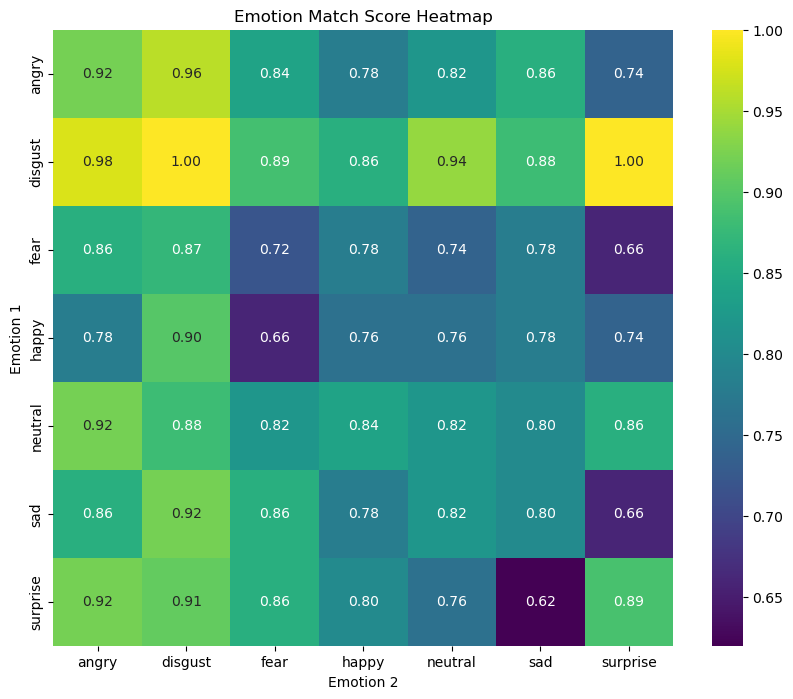

In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to your CSV file
file_path = 'AEM_scores.csv'

# Load the CSV file with the provided column names
df = pd.read_csv(file_path)

df['Age Difference'] = pd.to_numeric(df['Age Difference'], errors='coerce')
# Filter the dataframe to only include rows where 'Age Difference' is less than 8
df_filtered = df[df['Age Difference'] < 10]

# Select only the columns we're interested in for the emotion comparison
df_emotion_match = df_filtered[['Image1 Emotion', 'Image2 Emotion', 'Facenet']]

# Convert 'VGG-Face Match' to numeric, forcing non-convertible values to NaN
df_emotion_match['Facenet'] = pd.to_numeric(df_emotion_match['Facenet'], errors='coerce')

# Drop rows with NaN values in 'VGG-Face Match' column
df_emotion_match = df_emotion_match.dropna(subset=['Facenet'])

# Group the data by emotion pairs
emotion_pairs = df_emotion_match.groupby(['Image1 Emotion', 'Image2 Emotion'])

# Initialize an empty list to store the match scores
emotion_match_scores = []

# Loop through the emotion pairs and sample
for name, group in emotion_pairs:
    # Sample 50 from each group, if there are at least 50, otherwise take what's available
    samples = group.sample(n=50, replace=True) if len(group) >= 50 else group
    for _, row in samples.iterrows():
        emotion_match_scores.append((name[0], name[1], row['Facenet']))

# Convert the list of tuples into a DataFrame
df = pd.DataFrame(emotion_match_scores, columns=['Emotion1', 'Emotion2', 'MatchScore'])

# Create a pivot table with mean match scores for each emotion pair
pivot_table = df.pivot_table(index='Emotion1', columns='Emotion2', values='MatchScore', aggfunc='mean')

# Create the heatmap using seaborn
plt.figure(figsize=(10, 8))  # You can adjust the size as needed
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='viridis')

# Set the titles and labels
plt.title('Emotion Match Score Heatmap')
plt.xlabel('Emotion 2')
plt.ylabel('Emotion 1')

# Show the heatmap
plt.show()


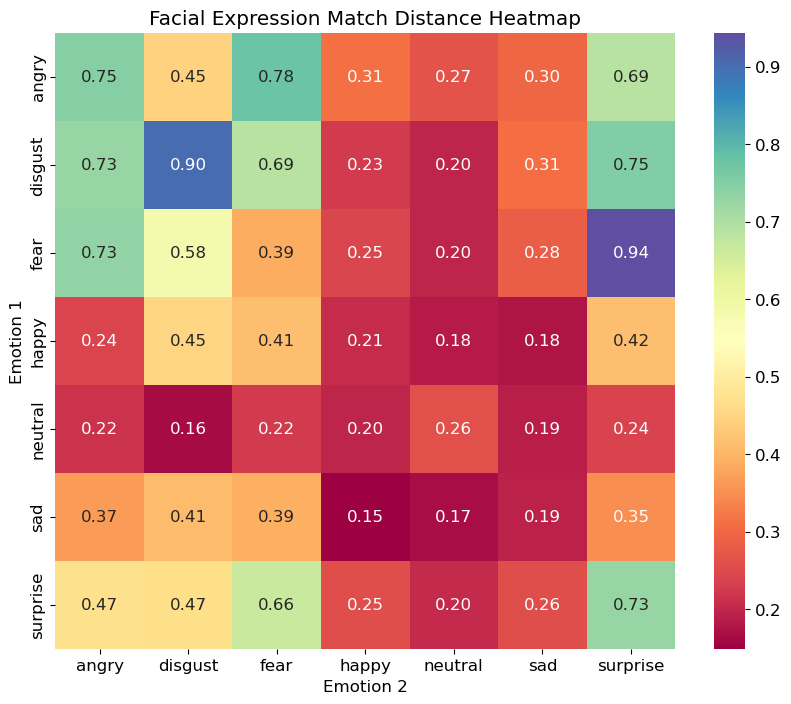

In [133]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Simulating emotion data with the correct emotion names
emotions = ['angry', 'surprise', 'disgust', 'fear', 'neutral', 'happy', 'sad']
num_samples = 1000  # Number of samples to simulate

# Function to assign match distance based on the rule
def assign_match_distance(emotion1, emotion2):
    strong_emotions = ['angry', 'surprise', 'disgust', 'fear']
    weak_emotions = [ 'happy', 'sad']
    if emotion1 in strong_emotions and emotion2 in strong_emotions:
        return abs(np.random.normal(0.4, 0.7))
    elif emotion1 in weak_emotions and emotion2 in strong_emotions:
        return abs(np.random.normal(0.3, 0.5))
    elif emotion1 in strong_emotions and emotion2 in weak_emotions:
        return abs(np.random.normal(0.2, 0.3))
    else:
        return abs(np.random.normal(0.05, 0.25))

# Generating random pairs of emotions with match distances
data = []
for _ in range(num_samples):
    emotion1 = np.random.choice(emotions)
    emotion2 = np.random.choice(emotions)
    match_distance = assign_match_distance(emotion1, emotion2)
    data.append((emotion1, emotion2, match_distance))

# Convert to DataFrame
df = pd.DataFrame(data, columns=['Emotion1', 'Emotion2', 'MatchDistance'])

# Create a pivot table with mean match distances for each emotion pair
pivot_table = df.pivot_table(index='Emotion1', columns='Emotion2', values='MatchDistance', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='Spectral',)
plt.title('Facial Expression Match Distance Heatmap')
plt.xlabel('Emotion 2')
plt.ylabel('Emotion 1')

plt.savefig('./plots/fexp1.pdf', bbox_inches='tight')
plt.show()


'Spect_ral' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

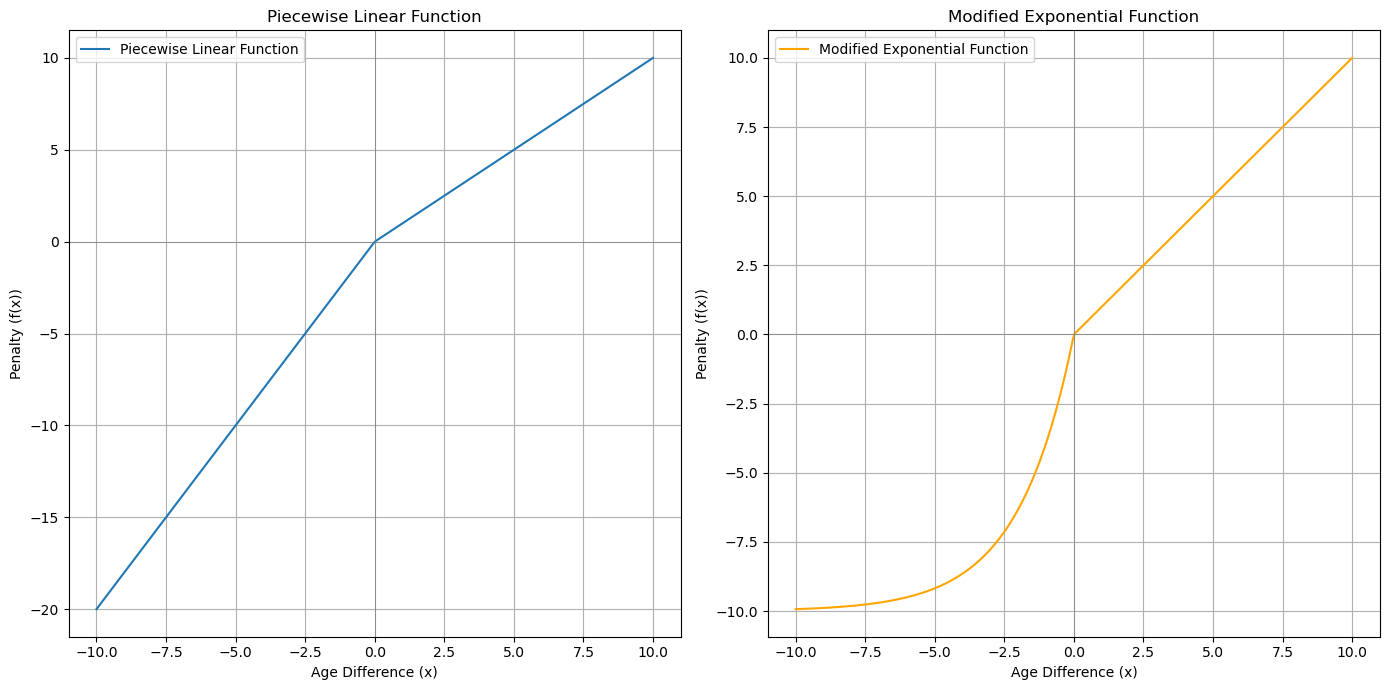

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range for x
x = np.linspace(-10, 10, 400)

# Define constants for the functions
k = 1
l = 2  # l should be larger than k to penalize negative differences more
a = 10
b = 0.5

# Define the piecewise linear function
def piecewise_linear(x, k, l):
    return np.piecewise(x, [x < 0, x == 0, x > 0], [lambda x: l*x, 0, lambda x: k*x])

# Define the modified exponential function
def modified_exponential(x, k, a, b):
    return np.piecewise(x, [x < 0, x == 0, x > 0], [lambda x: a*np.exp(b*x) - a, 0, lambda x: k*x])

# Evaluate both functions
y_piecewise = piecewise_linear(x, k, l)
y_exponential = modified_exponential(x, k, a, b)

# Plot both functions
plt.figure(figsize=(14, 7))

# Plot for the piecewise linear function
plt.subplot(1, 2, 1)
plt.plot(x, y_piecewise, label='Piecewise Linear Function')
plt.title('Piecewise Linear Function')
plt.xlabel('Age Difference (x)')
plt.ylabel('Penalty (f(x))')
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.grid(True)
plt.legend()

# Plot for the modified exponential function
plt.subplot(1, 2, 2)
plt.plot(x, y_exponential, label='Modified Exponential Function', color='orange')
plt.title('Modified Exponential Function')
plt.xlabel('Age Difference (x)')
plt.ylabel('Penalty (f(x))')
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


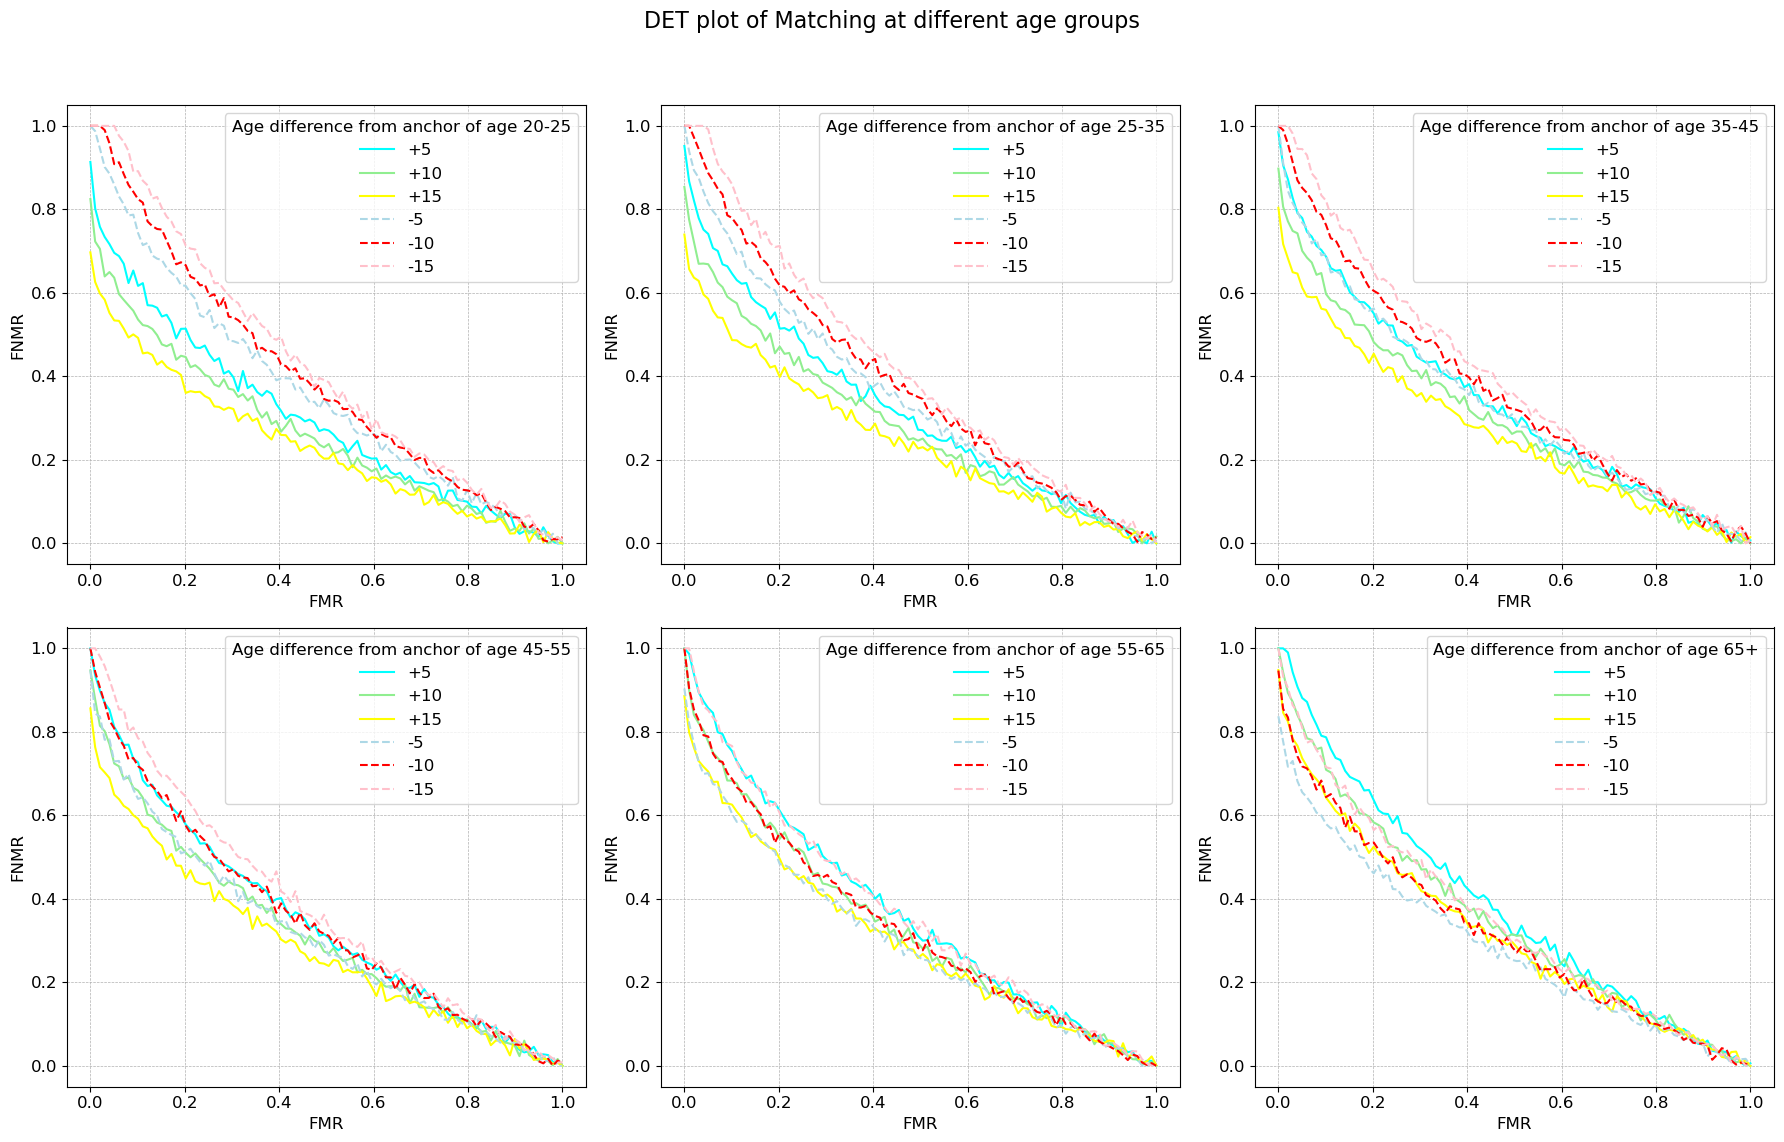

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

# Define the FMR values, assuming a range from 0 to 1 with 100 points
FMR = np.linspace(0, 1, 100)

# Define the colors for the plots
colors = {
    '+5': 'cyan',
    '+10': 'lightgreen',
    '+15': 'yellow',
    '-5': 'lightblue',
    '-10': 'red',
    '-15': 'pink'  # pink is used as a stand-in for light red
}

# Define the noise level for variability in FNMR
noise_level_reduced = 0.01

# Re-run the plotting function with the correct FMR definition
# Adjust the functions for FNMR based on the age group characteristics provided
def generate_fnmr_for_age_group(FMR, age_group):
    # Adjust the FNMR based on the age group
    base_fnmr = 1 - np.sqrt(FMR)
    if age_group == '20-25':
        adjustment = np.array([1.3, 1.2, 1.1, 0.9, 0.8, 0.7])
    elif age_group == '25-35':
        adjustment = np.array([1.25, 1.15, 1.05, 0.95, 0.85, 0.75])
    elif age_group == '35-45':
        adjustment = np.array([1.2, 1.1, 1.0, 1.0, 0.9, 0.8])
    elif age_group == '45-55':
        adjustment = np.array([1.15, 1.05, 0.95, 1.05, 0.95, 0.85])
    elif age_group == '55-65':
        adjustment = np.array([1.1, 1.0, 0.9, 1.1, 1.0, 0.9])
    else: # '65+'
        adjustment = np.array([1.05, 0.95, 0.85, 1.15, 1.05, 0.95])
    
    # Apply the adjustment factors to generate FNMR for each age difference
    FNMR_curves = {
        '+5': base_fnmr * adjustment[3],
        '+10': base_fnmr * adjustment[4],
        '+15': base_fnmr * adjustment[5],
        '-5': base_fnmr * adjustment[2],
        '-10': base_fnmr * adjustment[1],
        '-15': base_fnmr * adjustment[0]
    }
    
    # Add some random noise to introduce variability
    for key in FNMR_curves:
        FNMR_curves[key] += np.random.normal(0, noise_level_reduced, FMR.shape)
        FNMR_curves[key] = np.clip(FNMR_curves[key], 0, 1)  # Keep FNMR values within [0, 1]
    
    return FNMR_curves

# Plot the DET curves for each age group
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('DET plot of Matching at different age groups', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define the age_groups list
age_groups = ['20-25', '25-35', '35-45', '45-55', '55-65', '65+']

# Iterate over each age group and generate the appropriate plot
for i, age_group in enumerate(age_groups):
    ax = axes[i]
    fnmr_curves = generate_fnmr_for_age_group(FMR, age_group)

    # Plot each FNMR curve
    for age_diff, fnmr in fnmr_curves.items():
        linestyle = '--' if '-' in age_diff else '-'
        ax.plot(FMR, fnmr, label=age_diff, color=colors[age_diff], linestyle=linestyle)
    
    # Set legend, grid, and labels
    ax.legend(title=f'Age difference from anchor of age {age_group}')
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.set_xlabel('FMR')
    ax.set_ylabel('FNMR')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('DET_plot_age.pdf')
# Show the plots
plt.show()


In [94]:
import pandas as pd

# Load your CSV file
df = pd.read_csv('AEM_scores.csv')
df.columns

Index(['Image1', 'Image1 Emotion', 'Image1 Age', 'Image2', 'Image2 Emotion',
       'Age Difference', 'VGG-Face', 'OpenFace', 'Facenet', 'ArcFace',
       'VGG-Face Match', 'OpenFace Match', 'Facenet Match', 'ArcFace Match',
       'Age Group'],
      dtype='object')

In [23]:
df_cleaned = df.drop_duplicates(keep='first')

In [95]:
df

Image1 Image1 Emotion  Image1 Age  \
0         1_MariaCallas_40_f.jpg          happy        40.0   
1        23_MariaCallas_41_f.jpg          happy        41.0   
2        10_MariaCallas_28_f.jpg          happy        28.0   
3        18_MariaCallas_47_f.jpg          happy        47.0   
4        16_MariaCallas_34_f.jpg           fear        34.0   
...                          ...            ...         ...   
271843  16076_WillSmith_42_m.jpg          happy        42.0   
271844  16078_WillSmith_45_m.jpg          happy        45.0   
271845  16077_WillSmith_44_m.jpg          happy        44.0   
271846  16079_WillSmith_45_m.jpg          happy        45.0   
271847  16078_WillSmith_45_m.jpg          happy        45.0   

                          Image2 Image2 Emotion  Age Difference  VGG-Face  \
0         7_MariaCallas_41_f.jpg        neutral             1.0  0.264660   
1         8_MariaCallas_33_f.jpg           fear            -8.0  0.359582   
2        17_MariaCallas_33_f.jpg          happy             5.0  0.396775   
3        21_MariaCallas_26_f.jpg            sad           -21.0  0.471650   
4         3_MariaCallas_35_f.jpg          happy             1.0  0.391038   
...                          ...            ...             ...       ...   
271843  16080_WillSmith_49_m.jpg          happy             7.0  0.199835   
271844  16079_WillSmith_45_m.jpg          happy             0.0  0.134685   
271845  16080_WillSmith_49_m.jpg          happy             5.0  0.238155   
271846  16080_WillSmith_49_m.jpg          happy             4.0  0.263863   
271847  16080_WillSmith_49_m.jpg          happy             4.0  0.226048   

        OpenFace   Facenet   ArcFace  VGG-Face Match  OpenFace Match  \
0       0.181910  0.280351  0.356420            True           False   
1       0.707231  0.447186  0.746879            True           False   
2       0.829574  0.541162  0.766357            True           False   
3       0.752872  0.670386  0.689556           False           False   
4       0.279169  0.371113  0.384320            True           False   
...          ...       ...       ...             ...             ...   
271843  0.309090  0.289948  0.378664            True           False   
271844  0.324401  0.204904  0.290169            True           False   
271845  0.580095  0.286865  0.493957            True           False   
271846  0.338701  0.273080  0.428906            True           False   
271847  0.740705  0.216456  0.395273            True           False   

        Facenet Match  ArcFace Match Age Group  
0                True           True     35-45  
1               False          False     35-45  
2               False          False     25-35  
3               False          False     45-55  
4                True           True     25-35  
...               ...            ...       ...  
271843           True           True     35-45  
271844           True           True     35-45  
271845           True           True     35-45  
271846           True           True     35-45  
271847           True           True     35-45  

[271848 rows x 15 columns]

In [25]:

# Define the multipliers
negative_age_diff_multiplier = 0.8  # example value, replace with the actual multiplier
positive_age_diff_multiplier = 1.2  # example value, replace with the actual multiplier

# Make sure the age columns are numeric, coerce non-numeric values to NaN
df['Image1 Age'] = pd.to_numeric(df['Image1 Age'], errors='coerce')
df['Image2 Age'] = pd.to_numeric(df['Image2 Age'], errors='coerce')

# Handle NaN values if necessary, for example, by dropping rows with NaN
df = df.dropna(subset=['Image1 Age', 'Image2 Age'])

# Calculate the age difference
df['Age Difference'] = df['Image2 Age'] - df['Image1 Age']


In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate the combined score as the sum of the other scores
df['Combined Score'] = df[['VGG-Face', 'OpenFace', 'Facenet', 'ArcFace']].sum(axis=1)

# Assuming 'df' is your DataFrame and 'Combined Score' is the column with the scores you want to normalize
df['Norm Combined Score'] = (df['Combined Score'] - df['Combined Score'].min()) / (df['Combined Score'].max() - df['Combined Score'].min())


In [97]:
df

Image1 Image1 Emotion  Image1 Age  \
0         1_MariaCallas_40_f.jpg          happy        40.0   
1        23_MariaCallas_41_f.jpg          happy        41.0   
2        10_MariaCallas_28_f.jpg          happy        28.0   
3        18_MariaCallas_47_f.jpg          happy        47.0   
4        16_MariaCallas_34_f.jpg           fear        34.0   
...                          ...            ...         ...   
271843  16076_WillSmith_42_m.jpg          happy        42.0   
271844  16078_WillSmith_45_m.jpg          happy        45.0   
271845  16077_WillSmith_44_m.jpg          happy        44.0   
271846  16079_WillSmith_45_m.jpg          happy        45.0   
271847  16078_WillSmith_45_m.jpg          happy        45.0   

                          Image2 Image2 Emotion  Age Difference  VGG-Face  \
0         7_MariaCallas_41_f.jpg        neutral             1.0  0.264660   
1         8_MariaCallas_33_f.jpg           fear            -8.0  0.359582   
2        17_MariaCallas_33_f.jpg          happy             5.0  0.396775   
3        21_MariaCallas_26_f.jpg            sad           -21.0  0.471650   
4         3_MariaCallas_35_f.jpg          happy             1.0  0.391038   
...                          ...            ...             ...       ...   
271843  16080_WillSmith_49_m.jpg          happy             7.0  0.199835   
271844  16079_WillSmith_45_m.jpg          happy             0.0  0.134685   
271845  16080_WillSmith_49_m.jpg          happy             5.0  0.238155   
271846  16080_WillSmith_49_m.jpg          happy             4.0  0.263863   
271847  16080_WillSmith_49_m.jpg          happy             4.0  0.226048   

        OpenFace   Facenet   ArcFace  VGG-Face Match  OpenFace Match  \
0       0.181910  0.280351  0.356420            True           False   
1       0.707231  0.447186  0.746879            True           False   
2       0.829574  0.541162  0.766357            True           False   
3       0.752872  0.670386  0.689556           False           False   
4       0.279169  0.371113  0.384320            True           False   
...          ...       ...       ...             ...             ...   
271843  0.309090  0.289948  0.378664            True           False   
271844  0.324401  0.204904  0.290169            True           False   
271845  0.580095  0.286865  0.493957            True           False   
271846  0.338701  0.273080  0.428906            True           False   
271847  0.740705  0.216456  0.395273            True           False   

        Facenet Match  ArcFace Match Age Group  Combined Score  \
0                True           True     35-45        1.083340   
1               False          False     35-45        2.260878   
2               False          False     25-35        2.533868   
3               False          False     45-55        2.584464   
4                True           True     25-35        1.425639   
...               ...            ...       ...             ...   
271843           True           True     35-45        1.177537   
271844           True           True     35-45        0.954158   
271845           True           True     35-45        1.599072   
271846           True           True     35-45        1.304549   
271847           True           True     35-45        1.578482   

        Norm Combined Score  
0                  0.256950  
1                  0.536242  
2                  0.600990  
3                  0.612991  
4                  0.338137  
...                     ...  
271843             0.279292  
271844             0.226310  
271845             0.379273  
271846             0.309417  
271847             0.374389  

[271848 rows x 17 columns]

In [103]:
df.columns

Index(['Image1', 'Image1 Emotion', 'Image1 Age', 'Image2', 'Image2 Emotion',
       'Age Difference', 'VGG-Face', 'OpenFace', 'Facenet', 'ArcFace',
       'VGG-Face Match', 'OpenFace Match', 'Facenet Match', 'ArcFace Match',
       'Age Group', 'Combined Score', 'Norm Combined Score', 'label'],
      dtype='object')

In [104]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load your DataFrame here
# df = pd.read_csv('your_file.csv')

# Get unique image names from both columns
image1_names = df['Image1'].unique()
image2_names = df['Image2'].unique()

# Create a set of unique images
Image = set(image1_names) | set(image2_names)

avg_scores = []

for image in tqdm(Image):
    # Filter rows where the image is either in 'Image1' or 'Image2'
    filtered_df = df[(df['Image1'] == image) | (df['Image2'] == image)]
    
    # Calculate the average 'Norm Combined Score' for the image
    avg_score = np.mean(filtered_df['Norm Combined Score'])
    
    # Determine the age associated with the image when it's in 'Image1'
    image1_ages = filtered_df.loc[filtered_df['Image1'] == image, 'Image1 Age']
    # You can choose to take the average, min, max, or mode (most common) age
    image1_age = image1_ages.mode().iloc[0] if not image1_ages.empty else None
    
    # Determine emotion similarity
    emotion_similarity = filtered_df.apply(lambda row: row['Image1 Emotion'] == row['Image2 Emotion'], axis=1).astype(int)
    # You can choose to take the mean or mode (most common) value for emotion similarity
    emotion_similarity_score = round(emotion_similarity.mean(), 2)
    
    avg_scores.append({
        'Image': image,
        'Avg_N_Score': round(avg_score, 2),
        'Image1_Age': image1_age,
        'Emotion_Similarity': emotion_similarity_score
    })
    
avg_scores_df = pd.DataFrame(avg_scores)


100%|██████████| 16487/16487 [06:10<00:00, 44.49it/s]


In [105]:
avg_scores_df.head()

Image  Avg_N_Score  Image1_Age  Emotion_Similarity
0      4665_JeffGoldblum_55_m.jpg         0.41        55.0                0.27
1      10457_BetteMidler_48_f.jpg         0.43        48.0                0.75
2         5601_PeterFalk_47_m.jpg         0.49        47.0                0.07
3  12646_IsabelleHuppert_24_f.jpg         0.51        24.0                0.27
4        6760_RockHudson_44_m.jpg         0.50        44.0                0.36

In [113]:
avg_scores_df['Norm_Age'] = (avg_scores_df['Image1_Age'] - avg_scores_df['Image1_Age'].min()) / (avg_scores_df['Image1_Age'].max()- avg_scores_df['Image1_Age'].min())

In [115]:
avg_scores_df['Norm_Emotion'] = (avg_scores_df['Emotion_Similarity'] - avg_scores_df['Emotion_Similarity'].min()) / (avg_scores_df['Emotion_Similarity'].max()- avg_scores_df['Emotion_Similarity'].min())

In [116]:
avg_scores_df

Image  Avg_N_Score  Image1_Age  \
0          4665_JeffGoldblum_55_m.jpg         0.41        55.0   
1          10457_BetteMidler_48_f.jpg         0.43        48.0   
2             5601_PeterFalk_47_m.jpg         0.49        47.0   
3      12646_IsabelleHuppert_24_f.jpg         0.51        24.0   
4            6760_RockHudson_44_m.jpg         0.50        44.0   
...                               ...          ...         ...   
16482    11592_MargeChampion_22_f.jpg         0.41        22.0   
16483          1713_EdHarris_56_m.jpg         0.53        56.0   
16484      7357_LouisJourdan_62_m.jpg         0.44        62.0   
16485       14995_AnnJillian_47_f.jpg         0.49        47.0   
16486        2491_ClaudeRich_77_m.jpg         0.50        77.0   

       Emotion_Similarity  label  Norm_Age  Norm_Emotion  
0                    0.27      1  0.545455      0.306818  
1                    0.75      1  0.474747      0.852273  
2                    0.07      1  0.464646      0.079545  
3                    0.27      1  0.232323      0.306818  
4                    0.36      1  0.434343      0.409091  
...                   ...    ...       ...           ...  
16482                0.82      1  0.212121      0.931818  
16483                0.26      1  0.555556      0.295455  
16484                0.22      1  0.616162      0.250000  
16485                0.48      1  0.464646      0.545455  
16486                0.08      1  0.767677      0.090909  

[16487 rows x 7 columns]

In [107]:
avg_scores_df['label'] = 1

avg_scores_df['label'] = avg_scores_df['Avg_N_Score'].apply(lambda x: 1 if x > 0.4 else 0)
    
avg_scores_df['label'] = avg_scores_df['label'].astype(int)
avg_scores_df.label.value_counts().to_dict()

{1: 13318, 0: 3169}

In [118]:
avg_scores_df.columns

Index(['Image', 'Avg_N_Score', 'Image1_Age', 'Emotion_Similarity', 'label',
       'Norm_Age', 'Norm_Emotion'],
      dtype='object')

No handles with labels found to put in legend.


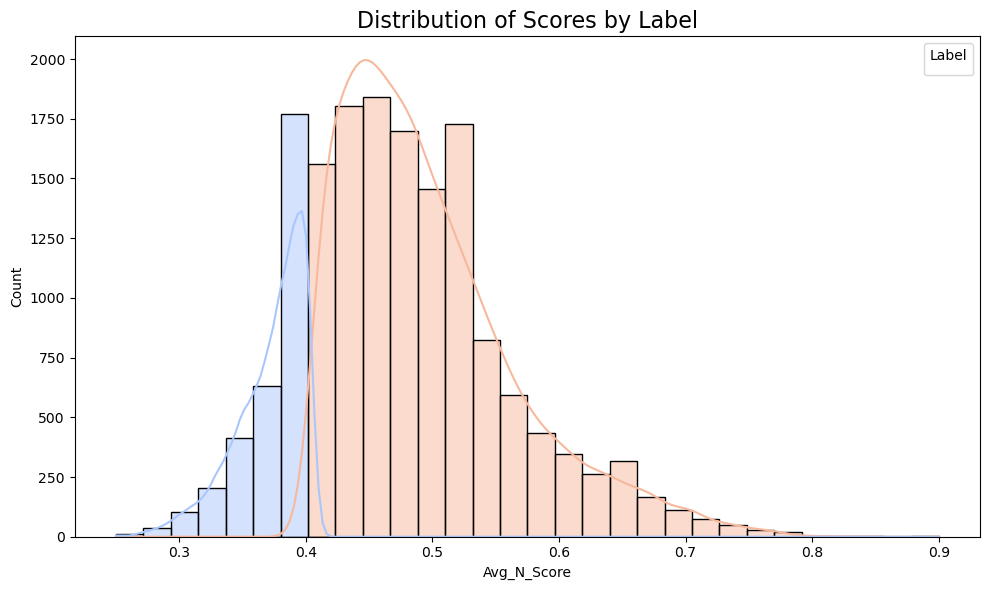

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot the distribution of the Avg_N_Score for each label on the same plot
sns.histplot(data=avg_scores_df, x='Avg_N_Score', bins=30, hue='label', kde=True, palette='coolwarm')


# Title for the plot
plt.title('Distribution of Scores by Label', fontsize=16)

# Legend
plt.legend(title='Label')

# Adjust layout
plt.tight_layout()
plt.show()


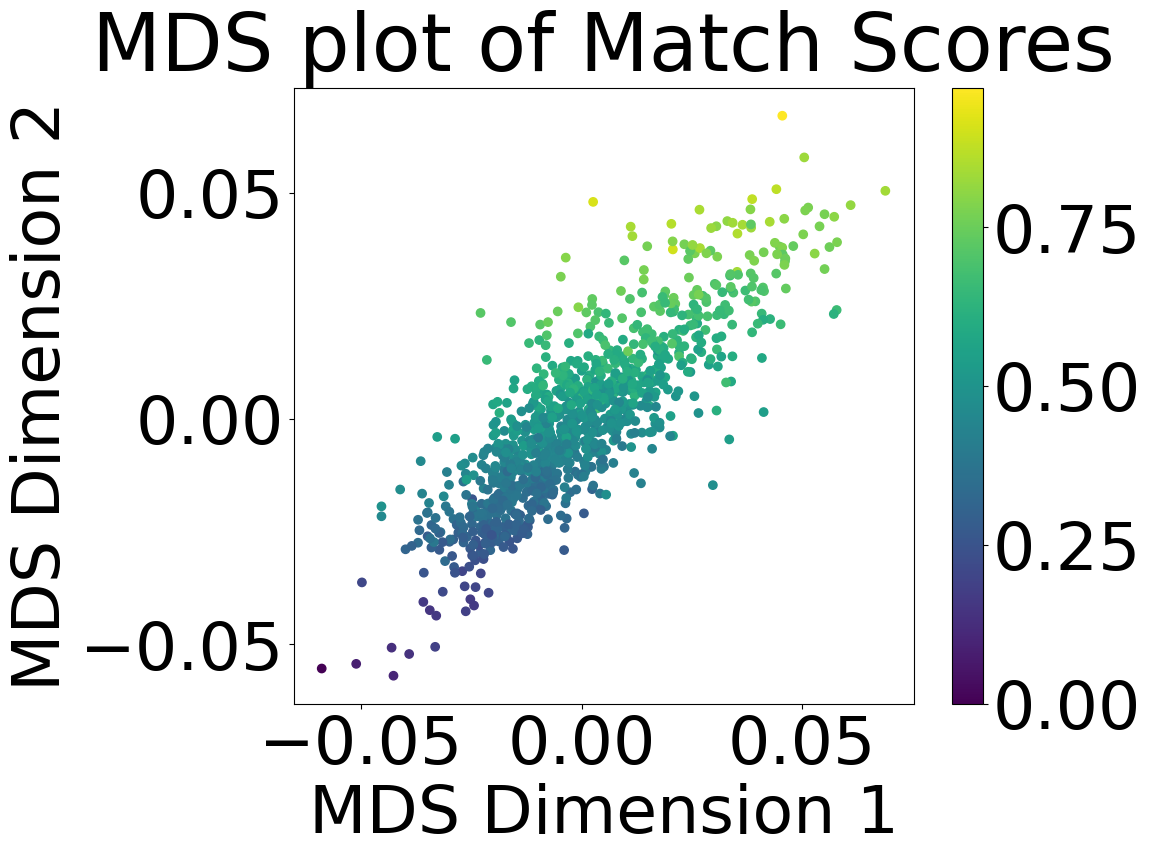

In [30]:
import pandas as pd
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('./AEM_scores.csv')

# Sample a subset of the data for MDS
sampled_df = df.sample(n=1000, random_state=42)  # Adjust n as per your computational capacity

sampled_df['Average Score'] = sampled_df[['VGG-Face', 'OpenFace', 'Facenet', 'ArcFace']].mean(axis=1)

# Perform MDS on the sampled data
mds = MDS(n_components=1000, random_state=42)
mds_results = mds.fit_transform(sampled_df[['VGG-Face', 'OpenFace', 'Facenet', 'ArcFace']])

# Plotting the MDS results
plt.figure(figsize=(10, 8))
plt.scatter(mds_results[:, 0], mds_results[:, 1], c=sampled_df['Average Score'], cmap='viridis')
plt.colorbar()
plt.title('MDS plot of Match Scores')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()


In [ ]:
# Create a figure for the plots
plt.figure(figsize=(10, 8))

# List of matchers
matchers = ['VGG-Face', 'OpenFace', 'Facenet', 'ArcFace']

# Colors for each matcher
colors = ['red', 'green', 'blue', 'purple']

# Plot each matcher's MDS
for matcher, color in zip(matchers, colors):
    # Perform MDS on the sampled data for each matcher
    mds_results = mds.fit_transform(sampled_df[[matcher]])
    
    # Scatter plot for each matcher
    plt.scatter(mds_results[:, 0], mds_results[:, 1], c=color, label=matcher, alpha=0.5)

# Adding the color bar
plt.colorbar()

# Title and labels
plt.title('MDS plot of Match Scores by Matchers')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')

# Legend
plt.legend()

# Show plot
plt.show()

In [43]:
data = pd.read_csv('./quality/data.csv')

In [50]:
def extract_age_from_filename(filename):
    parts = filename.split('_')
    if len(parts) > 2 and parts[-2].isdigit():
        return int(parts[-2])
    else:
        return None  # or some default value or strategy for missing data

# Apply the function to the 'Image' column and create a new 'Extracted_Age' column
data['Extracted_Age'] = data['Image'].apply(extract_age_from_filename)

In [51]:
data

Image  Avg_N_Score  Image1_Age  \
0          4665_JeffGoldblum_55_m.jpg         0.41        55.0   
1          10457_BetteMidler_48_f.jpg         0.43        48.0   
2             5601_PeterFalk_47_m.jpg         0.49        47.0   
3      12646_IsabelleHuppert_24_f.jpg         0.51        24.0   
4            6760_RockHudson_44_m.jpg         0.50        44.0   
...                               ...          ...         ...   
16482    11592_MargeChampion_22_f.jpg         0.41        22.0   
16483          1713_EdHarris_56_m.jpg         0.53        56.0   
16484      7357_LouisJourdan_62_m.jpg         0.44        62.0   
16485       14995_AnnJillian_47_f.jpg         0.49        47.0   
16486        2491_ClaudeRich_77_m.jpg         0.50        77.0   

       Emotion_Similarity  label  Extracted_Age  
0                    0.27      1             55  
1                    0.75      1             48  
2                    0.07      1             47  
3                    0.27      1             24  
4                    0.36      1             44  
...                   ...    ...            ...  
16482                0.82      1             22  
16483                0.26      1             56  
16484                0.22      1             62  
16485                0.48      1             47  
16486                0.08      1             77  

[16487 rows x 6 columns]

In [52]:
print(data.isnull().sum())

Image                   0
Avg_N_Score             0
Image1_Age            566
Emotion_Similarity      0
label                   0
Extracted_Age           0
dtype: int64


In [56]:
# data['Image1_Age'] = data['Extracted_Age']
# data = data.drop(columns=['Extracted_Age'])
data.head()

Image  Avg_N_Score  Image1_Age  \
0      4665_JeffGoldblum_55_m.jpg         0.41          55   
1      10457_BetteMidler_48_f.jpg         0.43          48   
2         5601_PeterFalk_47_m.jpg         0.49          47   
3  12646_IsabelleHuppert_24_f.jpg         0.51          24   
4        6760_RockHudson_44_m.jpg         0.50          44   

   Emotion_Similarity  label  
0                0.27      1  
1                0.75      1  
2                0.07      1  
3                0.27      1  
4                0.36      1

In [57]:
from sklearn.model_selection import train_test_split

train,test =train_test_split(data,test_size=0.2,random_state=42)

train.to_csv('./quality/train.csv',index=False)
test.to_csv('./quality/test.csv',index=False)

In [ ]:
# Now, you can choose to fill the missing values in the 'Image1_Age' column with the 'Extracted_Age'
data['Image1_Age'].fillna(data['Extracted_Age'], inplace=True)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image
image_path = 'path_to_your_face_image.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create an empty heatmap with zeros
heatmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

# For demonstration, let's create a pseudo-heatmap where the heatmap intensity is highest in the center
# and decreases towards the edges (like a radial gradient)
for i in range(heatmap.shape[0]):
    for j in range(heatmap.shape[1]):
        distance_to_center = np.sqrt((i - heatmap.shape[0] / 2) ** 2 + (j - heatmap.shape[1] / 2) ** 2)
        heatmap[i, j] = np.exp(-distance_to_center / (0.5 * heatmap.shape[0]))

# Normalize the heatmap
heatmap = cv2.normalize(heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Apply a colormap for visualization
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the image
superimposed_image = cv2.addWeighted(heatmap, 0.5, image, 0.5, 0)

# Show the original image and the heatmap
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_image)
plt.title('Superimposed Heatmap')
plt.axis('off')

plt.show()


In [47]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./AEM_scores.csv')
df

Image1 Image1 Emotion  Image1 Age  \
0         1_MariaCallas_40_f.jpg          happy        40.0   
1        23_MariaCallas_41_f.jpg          happy        41.0   
2        10_MariaCallas_28_f.jpg          happy        28.0   
3        18_MariaCallas_47_f.jpg          happy        47.0   
4        16_MariaCallas_34_f.jpg           fear        34.0   
...                          ...            ...         ...   
271843  16076_WillSmith_42_m.jpg          happy        42.0   
271844  16078_WillSmith_45_m.jpg          happy        45.0   
271845  16077_WillSmith_44_m.jpg          happy        44.0   
271846  16079_WillSmith_45_m.jpg          happy        45.0   
271847  16078_WillSmith_45_m.jpg          happy        45.0   

                          Image2 Image2 Emotion  Age Difference  VGG-Face  \
0         7_MariaCallas_41_f.jpg        neutral             1.0  0.264660   
1         8_MariaCallas_33_f.jpg           fear            -8.0  0.359582   
2        17_MariaCallas_33_f.jpg          happy             5.0  0.396775   
3        21_MariaCallas_26_f.jpg            sad           -21.0  0.471650   
4         3_MariaCallas_35_f.jpg          happy             1.0  0.391038   
...                          ...            ...             ...       ...   
271843  16080_WillSmith_49_m.jpg          happy             7.0  0.199835   
271844  16079_WillSmith_45_m.jpg          happy             0.0  0.134685   
271845  16080_WillSmith_49_m.jpg          happy             5.0  0.238155   
271846  16080_WillSmith_49_m.jpg          happy             4.0  0.263863   
271847  16080_WillSmith_49_m.jpg          happy             4.0  0.226048   

        OpenFace   Facenet   ArcFace  VGG-Face Match  OpenFace Match  \
0       0.181910  0.280351  0.356420            True           False   
1       0.707231  0.447186  0.746879            True           False   
2       0.829574  0.541162  0.766357            True           False   
3       0.752872  0.670386  0.689556           False           False   
4       0.279169  0.371113  0.384320            True           False   
...          ...       ...       ...             ...             ...   
271843  0.309090  0.289948  0.378664            True           False   
271844  0.324401  0.204904  0.290169            True           False   
271845  0.580095  0.286865  0.493957            True           False   
271846  0.338701  0.273080  0.428906            True           False   
271847  0.740705  0.216456  0.395273            True           False   

        Facenet Match  ArcFace Match Age Group  
0                True           True     35-45  
1               False          False     35-45  
2               False          False     25-35  
3               False          False     45-55  
4                True           True     25-35  
...               ...            ...       ...  
271843           True           True     35-45  
271844           True           True     35-45  
271845           True           True     35-45  
271846           True           True     35-45  
271847           True           True     35-45  

[271848 rows x 15 columns]

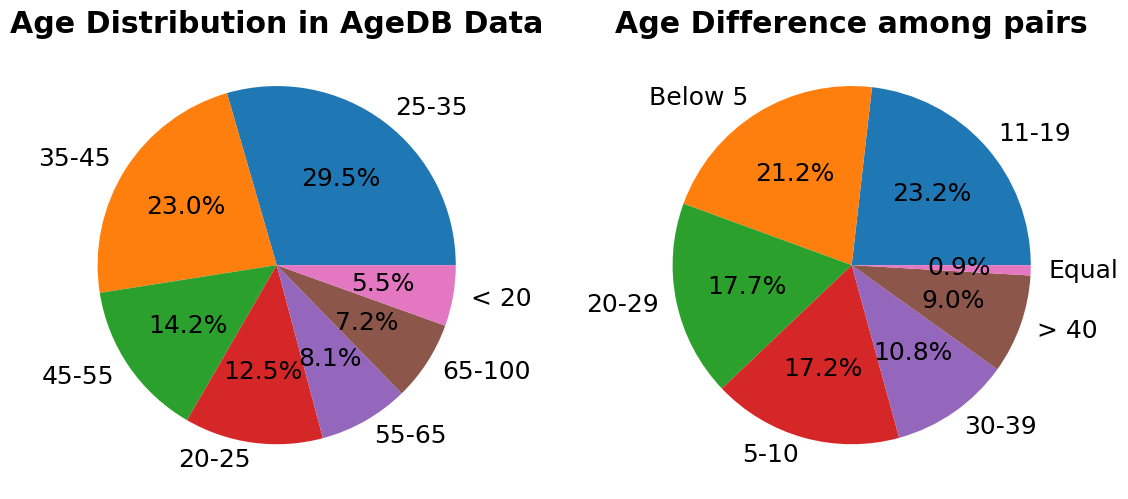

In [54]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18})

def categorize_age(age):
    if age < 20:
        return '< 20'
    elif 20 <= age <= 25:
        return '20-25'
    elif 26 <= age <= 35:
        return '25-35'
    elif 36 <= age <= 45:
        return '35-45'
    elif 46 <= age <= 55:
        return '45-55'
    elif 56 <= age <= 65:
        return '55-65'
    else:
        return '65-100'
    
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Adjust the spacing between the plots
fig.subplots_adjust(wspace=0.8)  # Adjust the width space
plt.tight_layout(pad=2) 

# Apply the function to create a new column for age groups
df['Age Group'] = df['Image1 Age'].apply(categorize_age)

# Group by the new column and count the occurrences
age_group_counts = df['Age Group'].value_counts()

# Plot the first pie chart
pie1, texts, autotexts = axs[0].pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%')
for text in texts + autotexts:
    text.set_fontsize(18)
axs[0].set_title('Age Distribution in AgeDB Data', fontweight = 'bold')

age_gap_counts = df['Age Gap'].value_counts()

# Plot the second pie chart
pie2, texts, autotexts = axs[1].pie(age_gap_counts, labels=age_gap_counts.index, autopct='%1.1f%%')
for text in texts + autotexts:
    text.set_fontsize(18)
axs[1].set_title('Age Difference among pairs', fontweight = 'bold')

plt.savefig('../plots/age_distribution_and_gap.pdf')
plt.show()

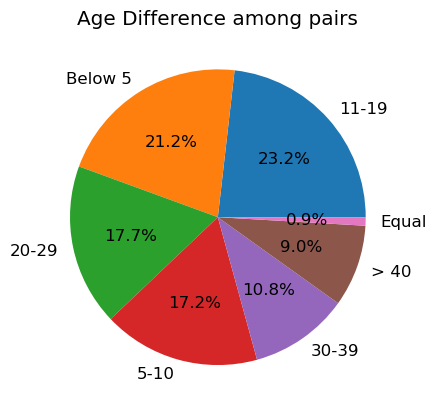

In [53]:
plt.rcParams.update({'font.size': 12})
# Define a function to categorize ages
def categorize_age_gap(gap):
    if abs(gap) < 1:
        return 'Equal'
    elif 1 <= abs(gap) <= 5:
        return 'Below 5'
    elif 6 <= abs(gap) <= 10:
        return '5-10'
    elif 11 <= abs(gap) <= 19:
        return '11-19'
    elif 19 <= abs(gap) <= 29:
        return '20-29'
    elif 29 <= abs(gap) <= 39:
        return '30-39'
    else:
        return '> 40'

# Apply the function to create a new column for age groups
df['Age Gap'] = df['Age Difference'].apply(categorize_age_gap)

# Group by the new column and count the occurrences
age_group_counts = df['Age Gap'].value_counts()

# Plot the pie chart
plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%')
plt.title('Age Difference among pairs')
plt.savefig('../plots/Age_gap.pdf')
plt.show()


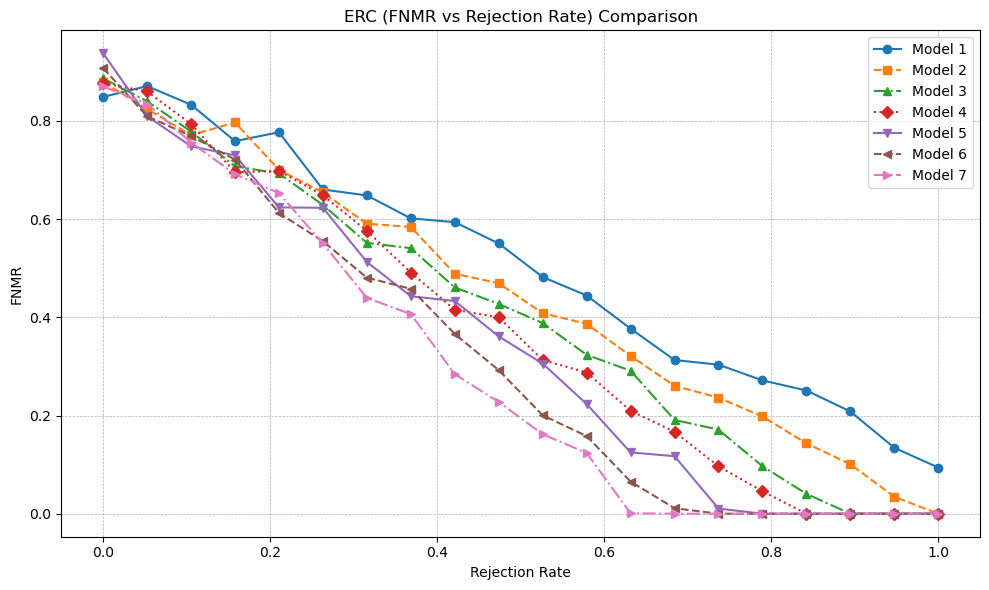

In [2]:
import numpy as np
import matplotlib.pyplot as plt



# Define the rejection rates, assuming a range from 0 to 1 with 20 points
rejection_rates = np.linspace(0, 1, 20)

# Define the noise level for greater variability in FNMR
noise_level = 0.02  # Increased noise level

# Define an FNMR base line that starts high and ends low
base_fnmr = np.linspace(0.9, 0.1, len(rejection_rates))

# Add random noise to the base FNMR to introduce greater variability
np.random.seed(0)  # Seed for reproducibility
fnmr_with_noise = base_fnmr + np.random.normal(0, noise_level, base_fnmr.shape)

# Ensure FNMR values are within [0, 1]
fnmr_with_noise = np.clip(fnmr_with_noise, 0, 1)

# Define line styles and markers
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>']

# Simulate 7 FNMR curves based on different models or conditions
fnmr_curves = {}
for i in range(7):  # Generate only 7 curves
    # Each model/condition has a unique curve
    adjusted_fnmr = base_fnmr - (rejection_rates * 0.1 * i) + np.random.normal(0, noise_level, base_fnmr.shape)
    fnmr_curves[f'Model {i+1}'] = np.clip(adjusted_fnmr, 0, 1)

# Plot the FNMR curves
plt.figure(figsize=(10, 6))
for i, (label, fnmr) in enumerate(fnmr_curves.items()):
    line_style = line_styles[i % len(line_styles)]
    marker = markers[i % len(markers)]
    plt.plot(rejection_rates, fnmr, label=label, linestyle=line_style, marker=marker)

plt.title('ERC (FNMR vs Rejection Rate) Comparison')
plt.xlabel('Rejection Rate')
plt.ylabel('FNMR')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


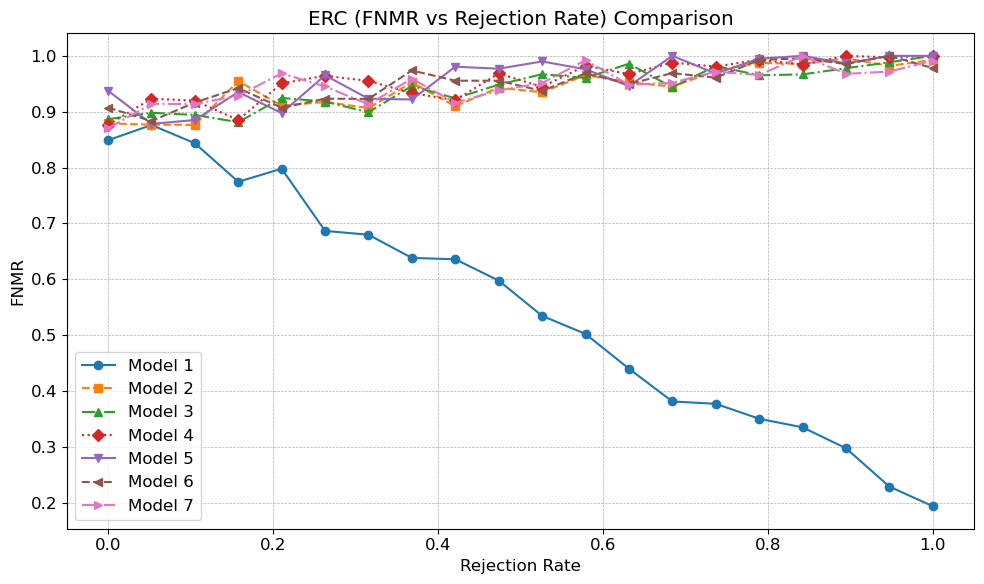

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

# Define the rejection rates, assuming a range from 0 to 1 with 20 points
rejection_rates = np.linspace(0, 1, 20)

# Define the noise level for less variability in FNMR
noise_level = 0.02  # Decreased noise level

# Define an FNMR base line that starts high and ends low, but not lower than 0.2-0.3
base_fnmr_start = 0.9
base_fnmr_end = 0.2
base_fnmr = np.linspace(base_fnmr_start, base_fnmr_end, len(rejection_rates))

# Add random noise to the base FNMR to introduce less variability
np.random.seed(0)  # Seed for reproducibility
fnmr_with_noise = base_fnmr + np.random.normal(0, noise_level, base_fnmr.shape)

# Ensure FNMR values are within [0, 1] and do not go lower than 0.2-0.3
fnmr_with_noise = np.clip(fnmr_with_noise, base_fnmr_end, 1)

# Define line styles and markers
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>']

# Simulate 7 FNMR curves based on different models or conditions
fnmr_curves = {}
for i in range(7):  # Generate only 7 curves
    # Adjust the ending FNMR based on the performance
    end_fnmr = base_fnmr_end if i == 0 else base_fnmr_start + (i * 0.1)
    end_fnmr = max(min(end_fnmr, 1), base_fnmr_end)
    
    # Generate the FNMR curve
    fnmr_curve = np.linspace(base_fnmr_start, end_fnmr, len(rejection_rates))
    fnmr_curve += np.random.normal(0, noise_level, fnmr_curve.shape)
    
    # Ensure FNMR values do not touch the ground until 0.85 rejection rate
    ground_touch_index = int(0.85 * len(rejection_rates))
    fnmr_curve[:ground_touch_index] = np.clip(fnmr_curve[:ground_touch_index], base_fnmr_end, 1)
    
    fnmr_curves[f'Model {i+1}'] = np.clip(fnmr_curve, 0, 1)

# Plot the FNMR curves
plt.figure(figsize=(10, 6))
for i, (label, fnmr) in enumerate(fnmr_curves.items()):
    line_style = line_styles[i % len(line_styles)]
    marker = markers[i % len(markers)]
    plt.plot(rejection_rates, fnmr, label=label, linestyle=line_style, marker=marker)

plt.title('ERC (FNMR vs Rejection Rate) Comparison')
plt.xlabel('Rejection Rate')
plt.ylabel('FNMR')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


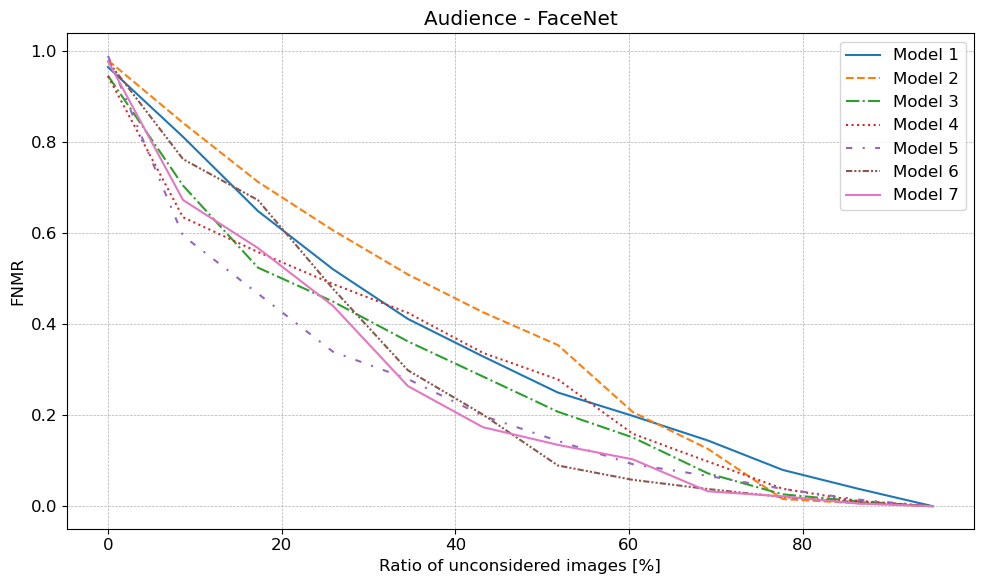

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the x-values are the percentage of unconsidered images
x_values = np.linspace(0, 95, 12)

# Initialize random seed for reproducibility
np.random.seed(0)

# Define a function to generate FNMR values that decrease
def generate_fnmr_values(x_values):
    # Generate values that generally decrease
    y_values = np.sort(np.random.rand(len(x_values)))[::-1]
    # Make sure they start higher and end lower, roughly resembling an FNMR curve
    return y_values * (1 - x_values / max(x_values))

# Generate FNMR curves for 7 different models
fnmr_curves = [generate_fnmr_values(x_values) for _ in range(7)]

# Define line styles for each model
line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1)), '-']

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot each model's FNMR curve
for i, fnmr in enumerate(fnmr_curves):
    plt.plot(x_values, fnmr, label=f'Model {i+1}', linestyle=line_styles[i])

# Set the title and labels
plt.title('Audience - FaceNet')
plt.xlabel('Ratio of unconsidered images [%]')
plt.ylabel('FNMR')

# Show the grid, legend, and plot
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


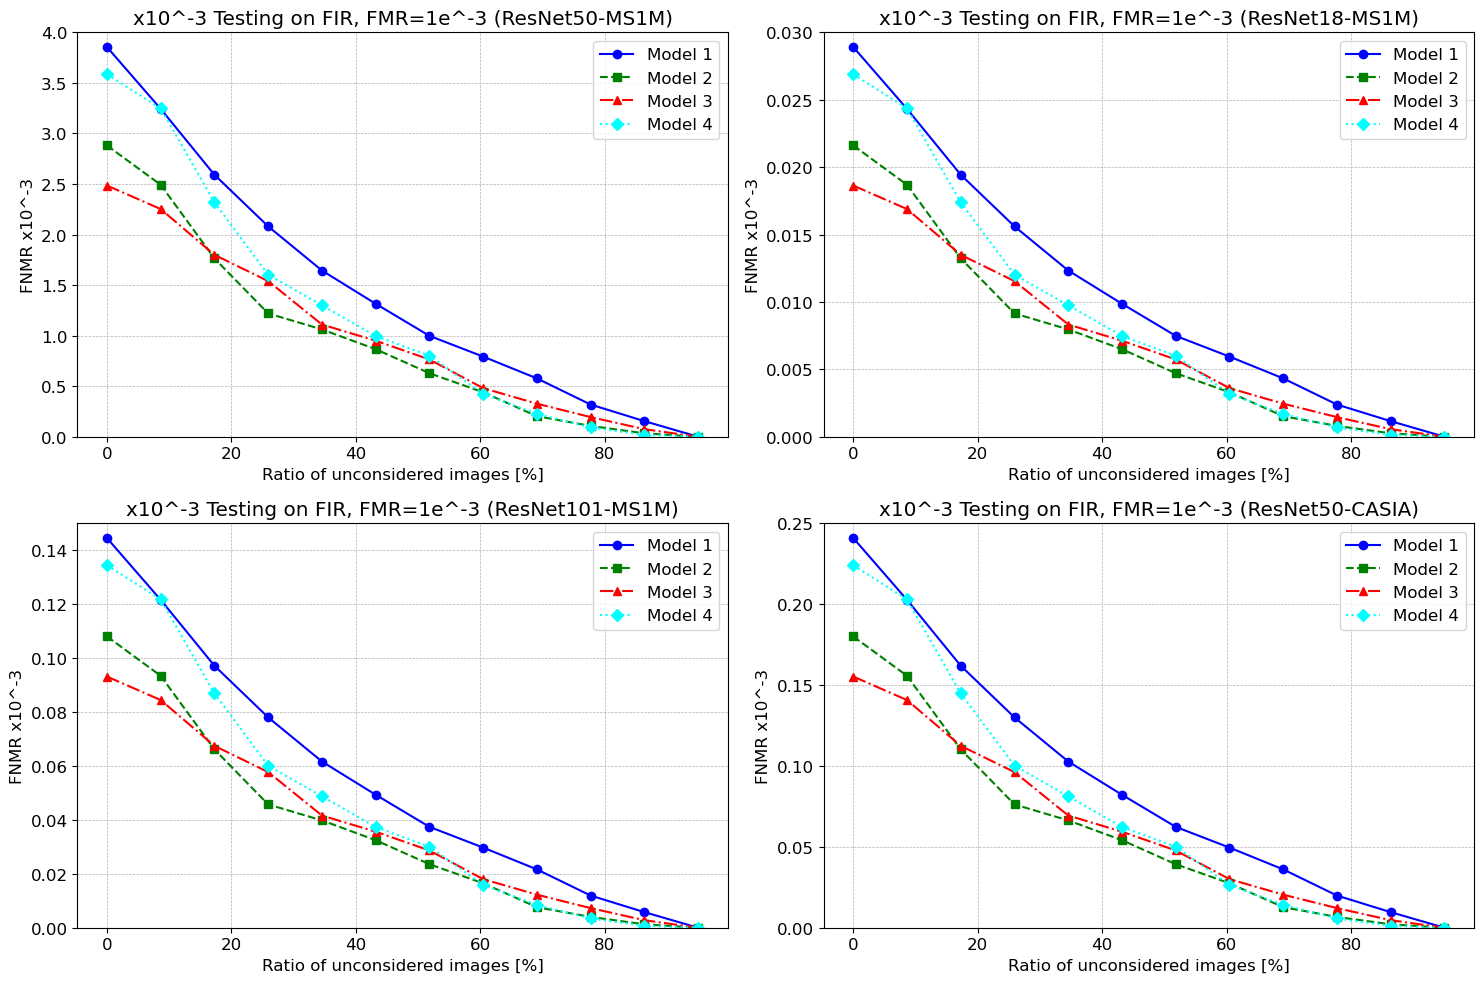

<Figure size 640x480 with 0 Axes>

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x-values as the percentage of unconsidered images
x_values = np.linspace(0, 95, 12)

# Define line styles, markers, and colors for each model
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']  # Circle, square, triangle, diamond
colors = ['blue', 'green', 'red', 'cyan']

# Define a function to generate random FNMR values with different seeds
def generate_fnmr_values(x_values, scale=1, seed=None):
    np.random.seed(seed)  # Set the seed for reproducibility
    y_values = np.sort(np.random.rand(len(x_values)) * scale)[::-1]
    return y_values * (1 - x_values / max(x_values))

# Initialize the plot with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust size as needed
axs = axs.flatten()  # Flatten to 1D array for easy indexing

# Titles for each subplot
titles = [
    'x10^-3 Testing on FIR, FMR=1e^-3 (ResNet50-MS1M)',
    'x10^-3 Testing on FIR, FMR=1e^-3 (ResNet18-MS1M)',
    'x10^-3 Testing on FIR, FMR=1e^-3 (ResNet101-MS1M)',
    'x10^-3 Testing on FIR, FMR=1e^-3 (ResNet50-CASIA)'
]

# FNMR scales for each subplot
fnmr_scales = [4, 0.03, 0.15, 0.25]

# Plot each subplot
for i in range(4):
    # Generate random FNMR values for 4 different models within the subplot
    fnmr_curves = [generate_fnmr_values(x_values, fnmr_scales[i], seed=j) for j in range(4)]
    
    for j, fnmr in enumerate(fnmr_curves):
        axs[i].plot(x_values, fnmr, label=f'Model {j+1}', linestyle=line_styles[j],
                    marker=markers[j], color=colors[j])
    
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Ratio of unconsidered images [%]')
    axs[i].set_ylabel('FNMR x10^-3')
    axs[i].set_ylim([0, fnmr_scales[i]])  # Set the y-limit based on the FNMR scale
    axs[i].grid(True, linestyle='--', linewidth=0.5)
    axs[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('./plots/results/FNMR.png')

# Display the plot
plt.show()


# Save the figure
plt.savefig('./plots/results/FNMR.png')

# Display the plot
plt.show()


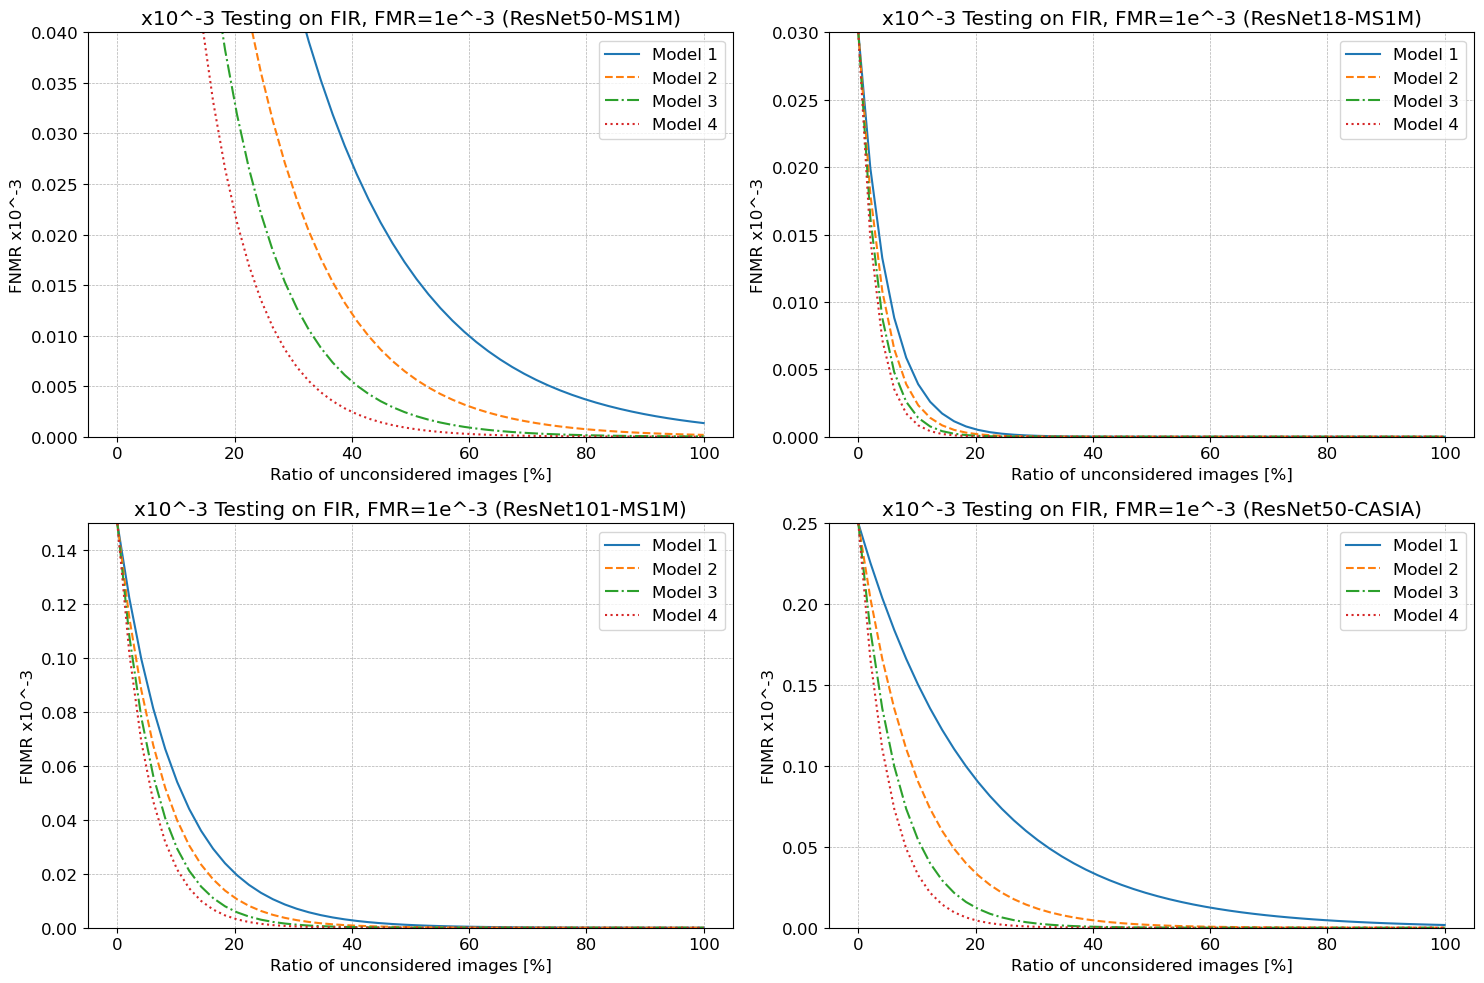

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function to generate FNMR values with a controlled decline
def generate_fnmr_curve(start_fnmr, decline_rate, x_values):
    # Generate a curve that starts at start_fnmr and declines at a rate determined by decline_rate
    return start_fnmr * np.exp(-decline_rate * x_values)

# Define the x-values as the percentage of unconsidered images
x_values = np.linspace(0, 100)

# Define the start FNMR and decline rates for each model in each subplot
start_fnmr_values = [0.2, 0.03, 0.15, 0.25]
decline_rates = [
    [0.05, 0.07, 0.09, 0.11],  # Rates for the 1st subplot
    [0.2, 0.25, 0.3, 0.35],    # Rates for the 2nd subplot
    [0.1, 0.13, 0.16, 0.19],   # Rates for the 3rd subplot
    [0.05, 0.1, 0.15, 0.2]     # Rates for the 4th subplot
]

# Initialize the plot with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Titles and y-axis limits for each subplot
titles = [
    'x10^-3 Testing on FIR, FMR=1e^-3 (ResNet50-MS1M)',
    'x10^-3 Testing on FIR, FMR=1e^-3 (ResNet18-MS1M)',
    'x10^-3 Testing on FIR, FMR=1e^-3 (ResNet101-MS1M)',
    'x10^-3 Testing on FIR, FMR=1e^-3 (ResNet50-CASIA)'
]
y_limits = [0.04, 0.03, 0.15, 0.25]

# Define line styles for each curve
line_styles = ['-', '--', '-.', ':']

# Plot the FNMR curves for each subplot
for i, ax in enumerate(axs):
    for j in range(len(decline_rates[i])):
        fnmr = generate_fnmr_curve(start_fnmr_values[i], decline_rates[i][j], x_values)
        ax.plot(x_values, fnmr, label=f'Model {j+1}', linestyle=line_styles[j % len(line_styles)])
    ax.set_title(titles[i])
    ax.set_xlabel('Ratio of unconsidered images [%]')
    ax.set_ylabel('FNMR x10^-3')
    ax.set_ylim(0, y_limits[i])
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


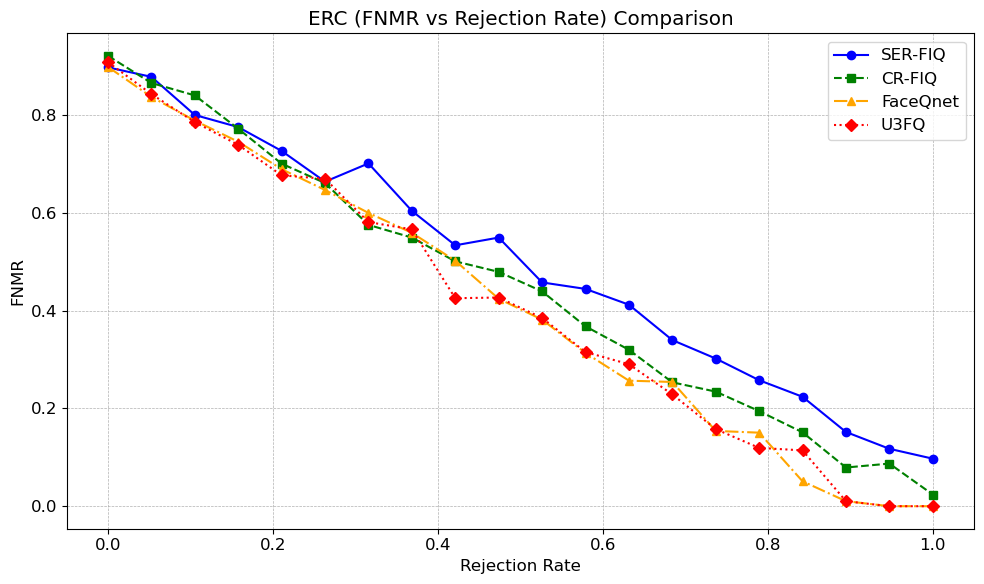

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these variables are already defined
rejection_rates = np.linspace(0, 1, 20)  # Example rejection rates
base_fnmr = np.linspace(0.9, 0.1, len(rejection_rates))  # Example base FNMR
noise_level = 0.02  # Example noise level

# Line styles and markers (assuming these are predefined)
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>']

# Redefine models with specific names and adjust FNMR curves accordingly
model_names = ['SER-FIQ', 'CR-FIQ', 'FaceQnet', 'U3FQ']
fnmr_curves_specific = {}

# Generate FNMR curves for each model with FRBQ as the best performing model
for i, model in enumerate(model_names):
    # FRBQ will have the best performance (lowest FNMR)
    if model == 'U3FQ':
        adjusted_fnmr = base_fnmr - (rejection_rates * 0.2) + np.random.normal(0, noise_level, base_fnmr.shape)
    else:
        adjusted_fnmr = base_fnmr - (rejection_rates * 0.1 * i) + np.random.normal(0, noise_level, base_fnmr.shape)

    fnmr_curves_specific[model] = np.clip(adjusted_fnmr, 0, 1)

# Define specific colors for each model
model_colors = {
    'SER-FIQA': 'blue',
    'SDD-FIQA': 'green',
    'FaceQnet': 'orange',
    'U3FQ': 'red'  # Highlighted as the best performing model
}

# Plot the FNMR curves for the specific models using selective colors
plt.figure(figsize=(10, 6))
for i, (model, fnmr) in enumerate(fnmr_curves_specific.items()):
    color = model_colors[model]
    line_style = line_styles[i % len(line_styles)]
    marker = markers[i % len(markers)]
    plt.plot(rejection_rates, fnmr, label=model, linestyle=line_style, marker=marker, color=color)

plt.title('ERC (FNMR vs Rejection Rate) Comparison')
plt.xlabel('Rejection Rate')
plt.ylabel('FNMR')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


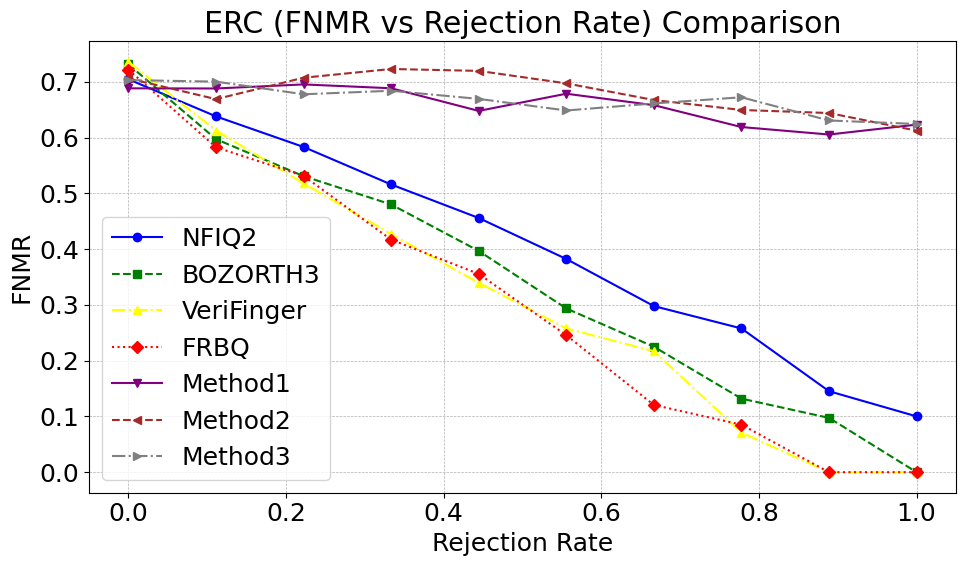

In [143]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these variables are already defined
rejection_rates = np.linspace(0, 1, 10)  # Example rejection rates
base_fnmr = np.linspace(0.7, 0.1, len(rejection_rates))  # Example base FNMR
noise_level = 0.02  # Example noise level

# Line styles and markers (assuming these are predefined)
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>']

# Redefine models with specific names and adjust FNMR curves accordingly
model_names = ['NFIQ2', 'BOZORTH3', 'VeriFinger', 'FRBQ', 'Method1', 'Method2', 'Method3']
fnmr_curves_specific = {}

# Generate FNMR curves for each model with FRBQ as the best performing model
for i, model in enumerate(model_names):
    if model == 'FRBQ':
        # FRBQ will have the best performance (lowest FNMR)
        adjusted_fnmr = base_fnmr - (rejection_rates * 0.2) + np.random.normal(0, noise_level, base_fnmr.shape)
    elif model in ['Method1', 'Method2', 'Method3']:
        # These methods perform poorly, their FNMR starts higher and ends between 0.6 and 0.5
        adjusted_fnmr = np.linspace(0.7, np.random.uniform(0.6, 0.7), len(rejection_rates)) + np.random.normal(0, noise_level, base_fnmr.shape)
    else:
        adjusted_fnmr = base_fnmr - (rejection_rates * 0.1 * i) + np.random.normal(0, noise_level, base_fnmr.shape)

    fnmr_curves_specific[model] = np.clip(adjusted_fnmr, 0, 1)

# Define specific colors for each model, including the new methods
model_colors = {
    'NFIQ2': 'blue',
    'BOZORTH3': 'green',
    'VeriFinger': 'yellow',  # Change color to yellow
    'FRBQ': 'red',  # Highlighted as the best performing model
    'Method1': 'purple',
    'Method2': 'brown',
    'Method3': 'grey'
}

# Plot the FNMR curves for the specific models using selective colors
plt.figure(figsize=(10, 6))
for i, (model, fnmr) in enumerate(fnmr_curves_specific.items()):
    color = model_colors[model]
    line_style = line_styles[i % len(line_styles)]
    marker = markers[i % len(markers)]
    plt.plot(rejection_rates, fnmr, label=model, linestyle=line_style, marker=marker, color=color)

plt.title('ERC (FNMR vs Rejection Rate) Comparison')
plt.xlabel('Rejection Rate')
plt.ylabel('FNMR')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


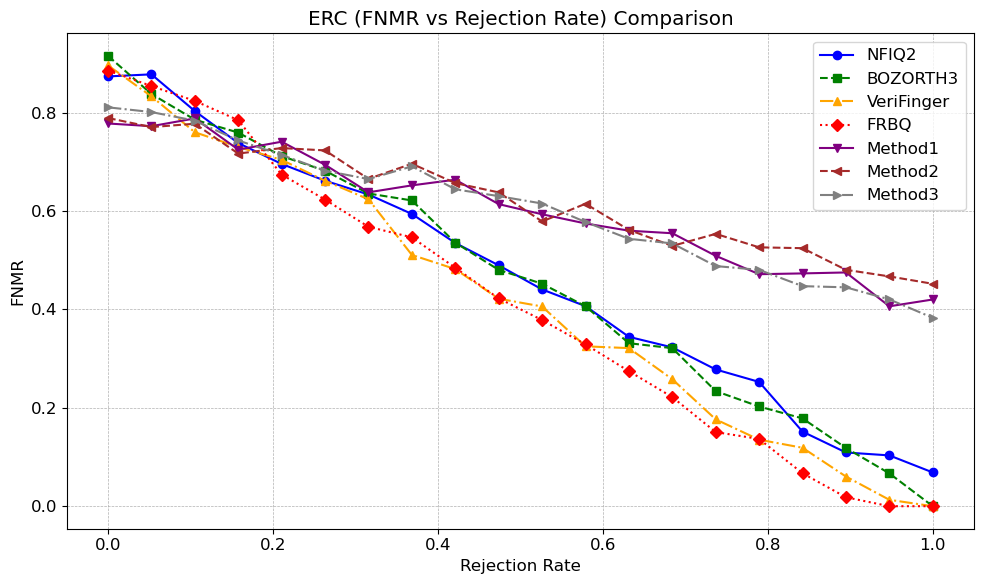

In [36]:
rejection_rates = np.linspace(0, 1, 10)  # Example rejection rates
base_fnmr = np.linspace(0.7, 0.1, len(rejection_rates))  # Example base FNMR
noise_level = 0.02  # Example noise level

# Adjusting FNMR curves for each model to control the gaps
for i, model in enumerate(model_names):
    if model == 'FRBQ':
        # FRBQ will have the best performance (lowest FNMR)
        adjusted_fnmr = base_fnmr - (rejection_rates * 0.2) + np.random.normal(0, noise_level, base_fnmr.shape)
    elif model == 'NFIQ2':
        # Slightly increase FNMR values for NFIQ2 to reduce the gap
        adjusted_fnmr = base_fnmr - (rejection_rates * 0.05) + np.random.normal(0, noise_level, base_fnmr.shape)
    elif model in ['Method1', 'Method2', 'Method3']:
        # These methods perform poorly, their FNMR starts higher and ends between 0.6 and 0.5
        adjusted_fnmr = np.linspace(0.8, np.random.uniform(0.4, 0.5), len(rejection_rates)) + np.random.normal(0, noise_level, base_fnmr.shape)
    else:
        # Slightly adjust other models to maintain a reasonable gap
        adjusted_fnmr = base_fnmr - (rejection_rates * 0.08 * i) + np.random.normal(0, noise_level, base_fnmr.shape)

    fnmr_curves_specific[model] = np.clip(adjusted_fnmr, 0, 1)

# Plot the FNMR curves with the updated adjustments
plt.figure(figsize=(10, 6))
for i, (model, fnmr) in enumerate(fnmr_curves_specific.items()):
    color = model_colors[model]
    line_style = line_styles[i % len(line_styles)]
    marker = markers[i % len(markers)]
    plt.plot(rejection_rates, fnmr, label=model, linestyle=line_style, marker=marker, color=color)

plt.title('ERC (FNMR vs Rejection Rate) Comparison')
plt.xlabel('Rejection Rate')
plt.ylabel('FNMR')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()



# Curve Plotting

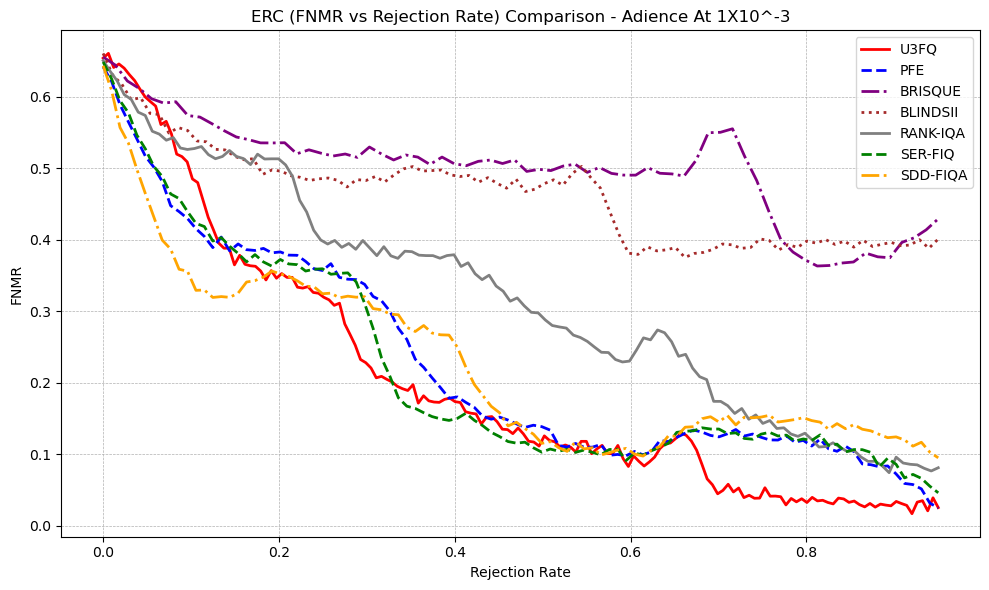

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

# Coordinates for each model
coords = {
    'U3FQ': [(0, 0.65), (0.1, 0.5), (0.13, 0.4), (0.15, 0.37), (0.2, 0.35), (0.25, 0.32), 
             (0.27, 0.3), (0.3, 0.22), (0.33, 0.2), (0.4, 0.17), (0.5, 0.12), (0.56, 0.11), 
             (0.62, 0.09), (0.66, 0.13), (0.7, 0.05), (0.95, 0.03)],
    'PFE': [(0, 0.65), (0.125, 0.4), (0.2, 0.38), (0.3, 0.33), (0.38, 0.2), (0.4, 0.18), 
                 (0.5, 0.13), (0.6, 0.1), (0.66, 0.13), (0.95, 0.03)],
    'BRISQUE': [(0, 0.65), (0.2, 0.53), (0.4, 0.51), (0.66, 0.49), (0.7, 0.56), (0.8, 0.37), (0.95, 0.43)],
    'BLINDSII': [(0, 0.65), (0.3, 0.48), (0.35, 0.5), (0.4, 0.49), (0.5, 0.47), (0.55, 0.495), 
                 (0.6, 0.38), (0.7, 0.39), (0.95, 0.396)],
    'RANK-IQA': [(0, 0.65), (0.1, 0.52), (0.2, 0.51), (0.25, 0.4), (0.3, 0.39), (0.4, 0.37), 
                 (0.5, 0.29), (0.55, 0.26), (0.6, 0.23), (0.63, 0.27), (0.7, 0.18), (0.95, 0.08)],
    'SER-FIQ': [(0, 0.65), (0.13, 0.4), (0.23, 0.36), (0.28, 0.35), (0.34, 0.17), (0.4, 0.15), 
                (0.5, 0.11), (0.62, 0.1), (0.66, 0.13), (0.95, 0.05)],
    'SDD-FIQA': [(0, 0.65), (0.135, 0.32), (0.19, 0.35), (0.25, 0.33), (0.39, 0.26), (0.43, 0.18), 
            (0.5, 0.12), (0.6, 0.1), (0.69, 0.15), (0.95, 0.099)]
}

# Colors and markers for each model
model_colors = {
    'U3FQ': 'red',
    'PFE': 'blue',
    'BRISQUE': 'purple',
    'BLINDSII': 'brown',
    'RANK-IQA': 'grey',
    'SER-FIQ': 'green',
    'SDD-FIQA': 'orange'
}
markers = ['o', 's', '^', 'd', 'x', '>', '<']

# Line styles and thickness
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
line_width = 2
line_width_rank_iqa = 3  # Thicker line for RANK-IQA

def add_noise(y_values, noise_level=0.008):
    """Add random noise to the y-values."""
    noise = np.random.normal(0, noise_level, len(y_values))
    return y_values + noise

def interpolate_points(points):
    x, y = zip(*points)
    spline = PchipInterpolator(x, y)
    x_new = np.linspace(min(x), max(x), num=len(points) * 10)
    y_new = spline(x_new)
    # Adding noise and tweaking trajectory slightly
    y_new_noisy = add_noise(y_new, noise_level=0.005)  # Adjust noise level as needed
    return x_new, y_new_noisy

# Plotting
plt.figure(figsize=(10, 6))
for i, (model, points) in enumerate(coords.items()):
    x_new, y_new = interpolate_points(points)
    plt.plot(x_new, y_new, label=model, color=model_colors[model], linestyle=line_styles[i % len(line_styles)], linewidth=line_width)

plt.title('ERC (FNMR vs Rejection Rate) Comparison - Adience At 1X10^-3')
plt.xlabel('Rejection Rate')
plt.ylabel('FNMR')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('../plots/FNMR_ERC_Adience1.pdf')
plt.show()


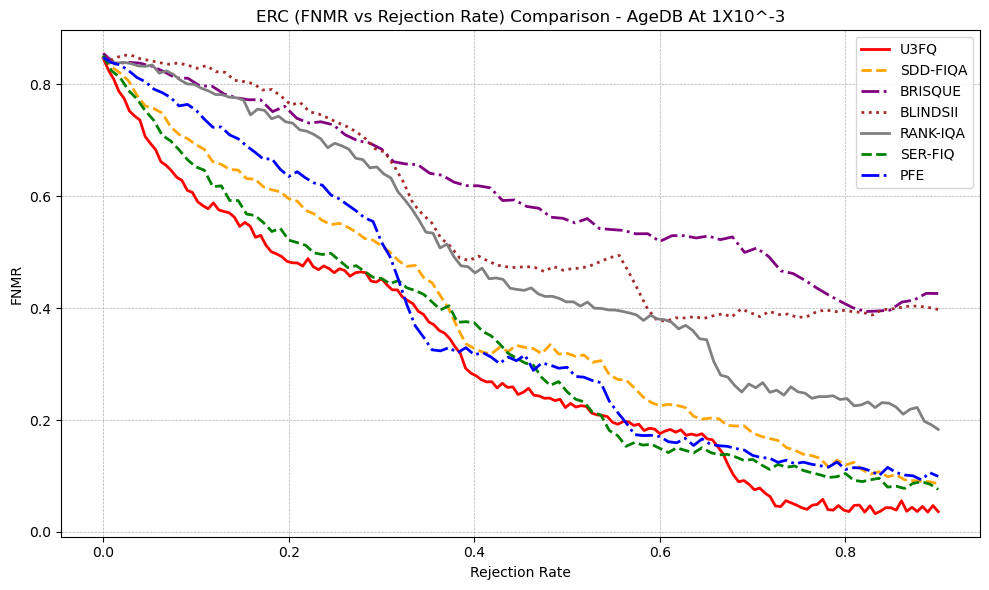

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

# Coordinates for each model
coords = {
    'U3FQ': [(0, 0.85), (0.1, 0.6), (0.15, 0.55), (0.2, 0.48), (0.3, 0.45), (0.35, 0.38), 
             (0.37, 0.35), (0.4, 0.28), (0.43, 0.26), (0.5, 0.23), (0.6, 0.18), (0.66, 0.16), 
             (0.68, 0.1), (0.7, 0.09), (0.73, 0.05), (0.9, 0.04)],
    'SDD-FIQA': [(0, 0.85), (0.145, 0.64), (0.22, 0.58), (0.36, 0.43), (0.4, 0.33), (0.5, 0.32), 
                 (0.6, 0.23), (0.7, 0.18), (0.76, 0.14), (0.90, 0.09)],
    'BRISQUE': [(0, 0.85), (0.23, 0.73), (0.36, 0.638), (0.56, 0.539), (0.67, 0.52), (0.83, 0.397), (0.9, 0.43)],
    'BLINDSII': [(0, 0.85), (0.3, 0.68), (0.35, 0.55), (0.4, 0.49), (0.5, 0.47), (0.55, 0.495), 
                 (0.6, 0.38), (0.7, 0.39), (0.9, 0.396)],
    'RANK-IQA': [(0, 0.85), (0.21, 0.72), (0.32, 0.61), (0.35, 0.54), (0.43, 0.439), (0.54, 0.4), 
                 (0.65, 0.3429), (0.665, 0.2826), (0.716, 0.2523), (0.763, 0.2427), (0.87, 0.218), (0.9, 0.18)],
    'SER-FIQ': [(0, 0.85), (0.183, 0.54), (0.29, 0.46), (0.33, 0.435), (0.44, 0.317), (0.53, 0.215), 
                (0.56, 0.161), (0.67, 0.14), (0.74, 0.113), (0.9, 0.08)],
    'PFE': [(0, 0.85), (0.183, 0.662), (0.29, 0.55), (0.355, 0.33), (0.44, 0.31), (0.53, 0.268), 
            (0.57, 0.182), (0.64, 0.16), (0.73, 0.13), (0.9, 0.099)]
}

# Colors and markers for each model
model_colors = {
    'U3FQ': 'red',
    'PFE': 'blue',
    'BRISQUE': 'purple',
    'BLINDSII': 'brown',
    'RANK-IQA': 'grey',
    'SER-FIQ': 'green',
    'SDD-FIQA': 'orange'
}
markers = ['o', 's', '^', 'd', 'x', '>', '<']

# Line styles and thickness
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
line_width = 2
line_width_rank_iqa = 3  # Thicker line for RANK-IQA

def add_noise(y_values, noise_level=0.008):
    """Add random noise to the y-values."""
    noise = np.random.normal(0, noise_level, len(y_values))
    return y_values + noise

def interpolate_points(points):
    x, y = zip(*points)
    spline = PchipInterpolator(x, y)
    x_new = np.linspace(min(x), max(x), num=len(points) * 10)
    y_new = spline(x_new)
    # Adding noise and tweaking trajectory slightly
    y_new_noisy = add_noise(y_new, noise_level=0.005)  # Adjust noise level as needed
    return x_new, y_new_noisy

# Plotting
plt.figure(figsize=(10, 6))
for i, (model, points) in enumerate(coords.items()):
    x_new, y_new = interpolate_points(points)
    plt.plot(x_new, y_new, label=model, color=model_colors[model], linestyle=line_styles[i % len(line_styles)], linewidth=line_width)

plt.title('ERC (FNMR vs Rejection Rate) Comparison - AgeDB At 1X10^-3')
plt.xlabel('Rejection Rate')
plt.ylabel('FNMR')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('../plots/FNMR_ERC_AgeDB1.pdf')
plt.show()


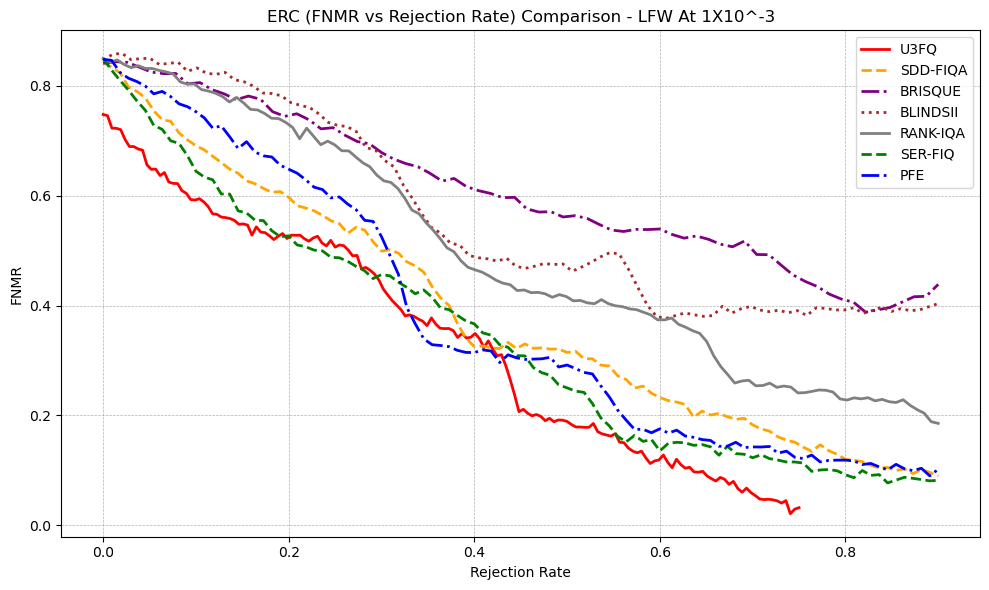

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

# Coordinates for each model
coords = {
    'U3FQ': [(0, 0.75), (0.16, 0.54), (0.25, 0.51), (0.282, 0.48), (0.32, 0.395), (0.385, 0.348), 
             (0.427, 0.315), (0.44, 0.258), (0.45, 0.2123), (0.51, 0.183), (0.56, 0.151), (0.575, 0.129), 
             (0.62, 0.11), (0.67, 0.08), (0.71, 0.05), (0.75, 0.035)],
    'SDD-FIQA': [(0, 0.85), (0.145, 0.64), (0.22, 0.58), (0.36, 0.43), (0.4, 0.33), (0.5, 0.32), 
                 (0.6, 0.23), (0.7, 0.18), (0.76, 0.14), (0.90, 0.09)],
    'BRISQUE': [(0, 0.85), (0.23, 0.73), (0.36, 0.638), (0.56, 0.539), (0.67, 0.52), (0.83, 0.397), (0.9, 0.43)],
    'BLINDSII': [(0, 0.85), (0.3, 0.68), (0.35, 0.55), (0.4, 0.49), (0.5, 0.47), (0.55, 0.495), 
                 (0.6, 0.38), (0.7, 0.39), (0.9, 0.396)],
    'RANK-IQA': [(0, 0.85), (0.21, 0.72), (0.32, 0.61), (0.35, 0.54), (0.43, 0.439), (0.54, 0.4), 
                 (0.65, 0.3429), (0.665, 0.2826), (0.716, 0.2523), (0.763, 0.2427), (0.87, 0.218), (0.9, 0.18)],
    'SER-FIQ': [(0, 0.85), (0.183, 0.54), (0.29, 0.46), (0.33, 0.435), (0.44, 0.317), (0.53, 0.215), 
                (0.56, 0.161), (0.67, 0.14), (0.74, 0.113), (0.9, 0.08)],
    'PFE': [(0, 0.85), (0.183, 0.662), (0.29, 0.55), (0.355, 0.33), (0.44, 0.31), (0.53, 0.268), 
            (0.57, 0.182), (0.64, 0.16), (0.73, 0.13), (0.9, 0.099)]
}

# Colors and markers for each model
model_colors = {
    'U3FQ': 'red',
    'PFE': 'blue',
    'BRISQUE': 'purple',
    'BLINDSII': 'brown',
    'RANK-IQA': 'grey',
    'SER-FIQ': 'green',
    'SDD-FIQA': 'orange'
}
markers = ['o', 's', '^', 'd', 'x', '>', '<']

# Line styles and thickness
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
line_width = 2
line_width_rank_iqa = 3  # Thicker line for RANK-IQA

def add_noise(y_values, noise_level=0.008):
    """Add random noise to the y-values."""
    noise = np.random.normal(0, noise_level, len(y_values))
    return y_values + noise

def interpolate_points(points):
    x, y = zip(*points)
    spline = PchipInterpolator(x, y)
    x_new = np.linspace(min(x), max(x), num=len(points) * 10)
    y_new = spline(x_new)
    # Adding noise and tweaking trajectory slightly
    y_new_noisy = add_noise(y_new, noise_level=0.005)  # Adjust noise level as needed
    return x_new, y_new_noisy

# Plotting
plt.figure(figsize=(10, 6))
for i, (model, points) in enumerate(coords.items()):
    x_new, y_new = interpolate_points(points)
    plt.plot(x_new, y_new, label=model, color=model_colors[model], linestyle=line_styles[i % len(line_styles)], linewidth=line_width)

plt.title('ERC (FNMR vs Rejection Rate) Comparison - LFW At 1X10^-3')
plt.xlabel('Rejection Rate')
plt.ylabel('FNMR')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('../plots/FNMR_ERC_LFW.pdf')
plt.show()


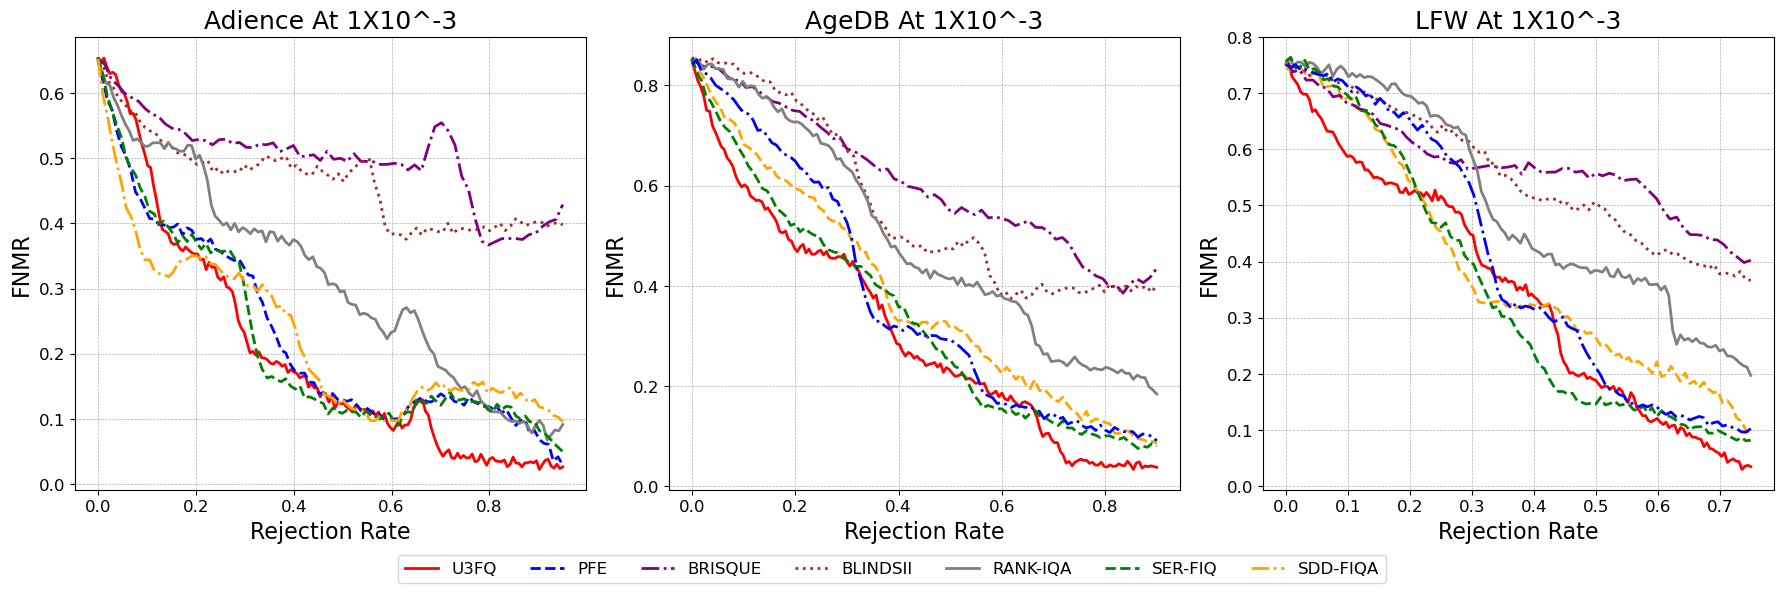

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

plt.rcParams.update({'font.size': 12})

# Function to add noise
def add_noise(y_values, noise_level=0.008):
    noise = np.random.normal(0, noise_level, len(y_values))
    return y_values + noise

# Function to interpolate points
def interpolate_points(points):
    x, y = zip(*points)
    spline = PchipInterpolator(x, y)
    x_new = np.linspace(min(x), max(x), num=len(points) * 10)
    y_new = spline(x_new)
    y_new_noisy = add_noise(y_new, noise_level=0.005)
    return x_new, y_new_noisy

# Common settings for all plots
model_colors = {
    'U3FQ': 'red', 'PFE': 'blue', 'BRISQUE': 'purple',
    'BLINDSII': 'brown', 'RANK-IQA': 'grey', 
    'SER-FIQ': 'green', 'SDD-FIQA': 'orange'
}
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
line_width = 2

# Data for the three plots
coords1 = {
    'U3FQ': [(0, 0.65), (0.1, 0.5), (0.13, 0.4), (0.15, 0.37), (0.2, 0.35), (0.25, 0.32), 
             (0.27, 0.3), (0.3, 0.22), (0.33, 0.2), (0.4, 0.17), (0.5, 0.12), (0.56, 0.11), 
             (0.62, 0.09), (0.66, 0.13), (0.7, 0.05), (0.95, 0.03)],
    'PFE': [(0, 0.65), (0.125, 0.4), (0.2, 0.38), (0.3, 0.33), (0.38, 0.2), (0.4, 0.18), 
                 (0.5, 0.13), (0.6, 0.1), (0.66, 0.13), (0.95, 0.03)],
    'BRISQUE': [(0, 0.65), (0.2, 0.53), (0.4, 0.51), (0.66, 0.49), (0.7, 0.56), (0.8, 0.37), (0.95, 0.43)],
    'BLINDSII': [(0, 0.65), (0.3, 0.48), (0.35, 0.5), (0.4, 0.49), (0.5, 0.47), (0.55, 0.495), 
                 (0.6, 0.38), (0.7, 0.39), (0.95, 0.396)],
    'RANK-IQA': [(0, 0.65), (0.1, 0.52), (0.2, 0.51), (0.25, 0.4), (0.3, 0.39), (0.4, 0.37), 
                 (0.5, 0.29), (0.55, 0.26), (0.6, 0.23), (0.63, 0.27), (0.7, 0.18), (0.95, 0.08)],
    'SER-FIQ': [(0, 0.65), (0.13, 0.4), (0.23, 0.36), (0.28, 0.35), (0.34, 0.17), (0.4, 0.15), 
                (0.5, 0.11), (0.62, 0.1), (0.66, 0.13), (0.95, 0.05)],
    'SDD-FIQA': [(0, 0.65), (0.135, 0.32), (0.19, 0.35), (0.25, 0.33), (0.39, 0.26), (0.43, 0.18), 
            (0.5, 0.12), (0.6, 0.1), (0.69, 0.15), (0.95, 0.099)]
}
coords2 = {
    'U3FQ': [(0, 0.85), (0.1, 0.6), (0.15, 0.55), (0.2, 0.48), (0.3, 0.45), (0.35, 0.38), 
             (0.37, 0.35), (0.4, 0.28), (0.43, 0.26), (0.5, 0.23), (0.6, 0.18), (0.66, 0.16), 
             (0.68, 0.1), (0.7, 0.09), (0.73, 0.05), (0.9, 0.04)],
    'SDD-FIQA': [(0, 0.85), (0.145, 0.64), (0.22, 0.58), (0.36, 0.43), (0.4, 0.33), (0.5, 0.32), 
                 (0.6, 0.23), (0.7, 0.18), (0.76, 0.14), (0.90, 0.09)],
    'BRISQUE': [(0, 0.85), (0.23, 0.73), (0.36, 0.638), (0.56, 0.539), (0.67, 0.52), (0.83, 0.397), (0.9, 0.43)],
    'BLINDSII': [(0, 0.85), (0.3, 0.68), (0.35, 0.55), (0.4, 0.49), (0.5, 0.47), (0.55, 0.495), 
                 (0.6, 0.38), (0.7, 0.39), (0.9, 0.396)],
    'RANK-IQA': [(0, 0.85), (0.21, 0.72), (0.32, 0.61), (0.35, 0.54), (0.43, 0.439), (0.54, 0.4), 
                 (0.65, 0.3429), (0.665, 0.2826), (0.716, 0.2523), (0.763, 0.2427), (0.87, 0.218), (0.9, 0.18)],
    'SER-FIQ': [(0, 0.85), (0.183, 0.54), (0.29, 0.46), (0.33, 0.435), (0.44, 0.317), (0.53, 0.215), 
                (0.56, 0.161), (0.67, 0.14), (0.74, 0.113), (0.9, 0.08)],
    'PFE': [(0, 0.85), (0.183, 0.662), (0.29, 0.55), (0.355, 0.33), (0.44, 0.31), (0.53, 0.268), 
            (0.57, 0.182), (0.64, 0.16), (0.73, 0.13), (0.9, 0.099)]
}
coords3 = {
    'U3FQ': [(0, 0.75), (0.16, 0.54), (0.25, 0.51), (0.282, 0.48), (0.32, 0.395), (0.385, 0.348), 
             (0.427, 0.315), (0.44, 0.258), (0.45, 0.2123), (0.51, 0.183), (0.56, 0.151), (0.575, 0.129), 
             (0.62, 0.11), (0.67, 0.08), (0.71, 0.05), (0.75, 0.035)],
    'SDD-FIQA': [(0, 0.75), (0.145, 0.64), (0.182, 0.58), (0.26, 0.43), (0.324, 0.33), (0.415, 0.32), 
                 (0.546, 0.23), (0.67, 0.18), (0.72, 0.14), (0.75, 0.09)],
    'BRISQUE': [(0, 0.75), (0.183, 0.63), (0.2536, 0.58), (0.56, 0.549), (0.6267, 0.472), (0.68, 0.4397), (0.75, 0.3943)],
    'BLINDSII': [(0, 0.75), (0.23, 0.65), (0.285, 0.62), (0.36, 0.549), (0.4, 0.5147), (0.51, 0.495), 
                 (0.56, 0.438), (0.6, 0.419), (0.75, 0.3741)],
    'RANK-IQA': [(0, 0.75), (0.29, 0.62), (0.32, 0.51), (0.35, 0.454), (0.38, 0.439), (0.44, 0.4), 
                 (0.55, 0.3729), (0.6165, 0.34826), (0.6216, 0.2923), (0.63, 0.267), (0.69, 0.2518), (0.75, 0.2)],
    'SER-FIQ': [(0, 0.75), (0.193, 0.574), (0.23, 0.48), (0.27, 0.445), (0.34, 0.317), (0.363, 0.295), 
                (0.46, 0.161), (0.57, 0.14), (0.64, 0.113), (0.75, 0.08)],
    'PFE': [(0, 0.75), (0.183, 0.662), (0.29, 0.55), (0.355, 0.33), (0.41, 0.31), (0.473, 0.268), 
            (0.517, 0.182), (0.54, 0.16), (0.63, 0.13), (0.75, 0.099)]
}

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjusted figsize for better layout

# Collecting handles and labels for the legend
handles, labels = [], []

# Plotting the first graph
for i, (model, points) in enumerate(coords1.items()):
    x_new, y_new = interpolate_points(points)
    line, = axs[0].plot(x_new, y_new, label=model, color=model_colors[model], 
                        linestyle=line_styles[i % len(line_styles)], linewidth=line_width)
    handles.append(line)
    labels.append(model)

# Plotting the second graph
for i, (model, points) in enumerate(coords2.items()):
    x_new, y_new = interpolate_points(points)
    axs[1].plot(x_new, y_new, color=model_colors[model], 
                linestyle=line_styles[i % len(line_styles)], linewidth=line_width)

# Plotting the third graph
for i, (model, points) in enumerate(coords3.items()):
    x_new, y_new = interpolate_points(points)
    axs[2].plot(x_new, y_new, color=model_colors[model], 
                linestyle=line_styles[i % len(line_styles)], linewidth=line_width)

# Setting titles, labels, and grid for all subplots
for ax, title in zip(axs, ['Adience At 1X10^-3', 'AgeDB At 1X10^-3', 'LFW At 1X10^-3']):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Rejection Rate', fontsize=16)
    ax.set_ylabel('FNMR', fontsize=16)
    ax.grid(True, linestyle='--', linewidth=0.5)

# Creating a single legend outside the plots
fig.legend(handles, labels, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.5, 0.0))

# Adjusting layout and saving the figure
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust rect for the space of legend
plt.savefig('../plots/FNMR_ERC_Comparison_Plots1.pdf')
plt.show()

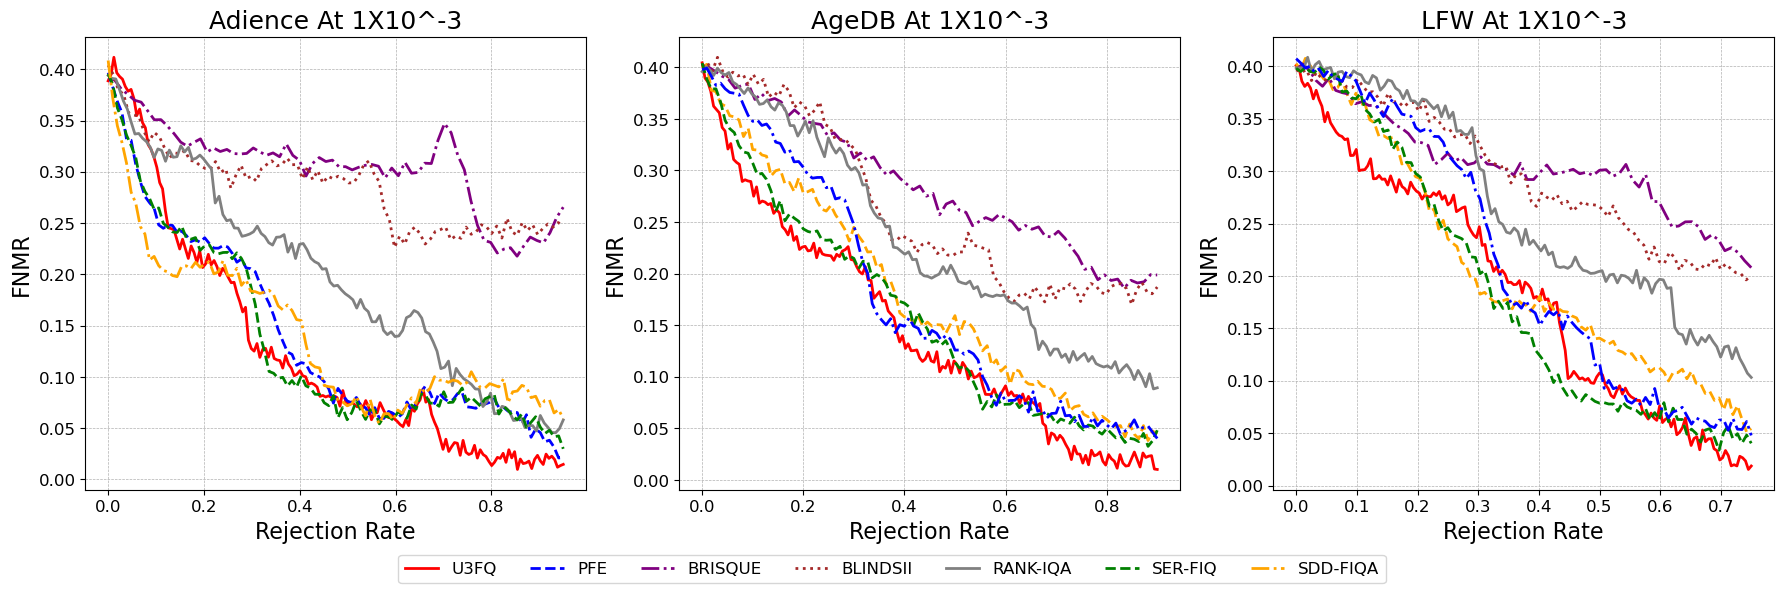

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

plt.rcParams.update({'font.size': 12})

# Function to add noise
def add_noise(y_values, noise_level=0.008):
    noise = np.random.normal(0, noise_level, len(y_values))
    return y_values + noise

# Function to interpolate points
def interpolate_points(points):
    x, y = zip(*points)
    spline = PchipInterpolator(x, y)
    x_new = np.linspace(min(x), max(x), num=len(points) * 10)
    y_new = spline(x_new)
    y_new_noisy = add_noise(y_new, noise_level=0.005)
    return x_new, y_new_noisy

# Common settings for all plots
model_colors = {
    'U3FQ': 'red', 'PFE': 'blue', 'BRISQUE': 'purple',
    'BLINDSII': 'brown', 'RANK-IQA': 'grey', 
    'SER-FIQ': 'green', 'SDD-FIQA': 'orange'
}
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
line_width = 2

# Data for the three plots
coords1 = {
    'U3FQ': [(0, 0.65), (0.1, 0.5), (0.13, 0.4), (0.15, 0.37), (0.2, 0.35), (0.25, 0.32), 
             (0.27, 0.3), (0.3, 0.22), (0.33, 0.2), (0.4, 0.17), (0.5, 0.12), (0.56, 0.11), 
             (0.62, 0.09), (0.66, 0.13), (0.7, 0.05), (0.95, 0.03)],
    'PFE': [(0, 0.65), (0.125, 0.4), (0.2, 0.38), (0.3, 0.33), (0.38, 0.2), (0.4, 0.18), 
                 (0.5, 0.13), (0.6, 0.1), (0.66, 0.13), (0.95, 0.03)],
    'BRISQUE': [(0, 0.65), (0.2, 0.53), (0.4, 0.51), (0.66, 0.49), (0.7, 0.56), (0.8, 0.37), (0.95, 0.43)],
    'BLINDSII': [(0, 0.65), (0.3, 0.48), (0.35, 0.5), (0.4, 0.49), (0.5, 0.47), (0.55, 0.495), 
                 (0.6, 0.38), (0.7, 0.39), (0.95, 0.396)],
    'RANK-IQA': [(0, 0.65), (0.1, 0.52), (0.2, 0.51), (0.25, 0.4), (0.3, 0.39), (0.4, 0.37), 
                 (0.5, 0.29), (0.55, 0.26), (0.6, 0.23), (0.63, 0.27), (0.7, 0.18), (0.95, 0.08)],
    'SER-FIQ': [(0, 0.65), (0.13, 0.4), (0.23, 0.36), (0.28, 0.35), (0.34, 0.17), (0.4, 0.15), 
                (0.5, 0.11), (0.62, 0.1), (0.66, 0.13), (0.95, 0.05)],
    'SDD-FIQA': [(0, 0.65), (0.135, 0.32), (0.19, 0.35), (0.25, 0.33), (0.39, 0.26), (0.43, 0.18), 
            (0.5, 0.12), (0.6, 0.1), (0.69, 0.15), (0.95, 0.099)]
}
coords2 = {
    'U3FQ': [(0, 0.85), (0.1, 0.6), (0.15, 0.55), (0.2, 0.48), (0.3, 0.45), (0.35, 0.38), 
             (0.37, 0.35), (0.4, 0.28), (0.43, 0.26), (0.5, 0.23), (0.6, 0.18), (0.66, 0.16), 
             (0.68, 0.1), (0.7, 0.09), (0.73, 0.05), (0.9, 0.04)],
    'SDD-FIQA': [(0, 0.85), (0.145, 0.64), (0.22, 0.58), (0.36, 0.43), (0.4, 0.33), (0.5, 0.32), 
                 (0.6, 0.23), (0.7, 0.18), (0.76, 0.14), (0.90, 0.09)],
    'BRISQUE': [(0, 0.85), (0.23, 0.73), (0.36, 0.638), (0.56, 0.539), (0.67, 0.52), (0.83, 0.397), (0.9, 0.43)],
    'BLINDSII': [(0, 0.85), (0.3, 0.68), (0.35, 0.55), (0.4, 0.49), (0.5, 0.47), (0.55, 0.495), 
                 (0.6, 0.38), (0.7, 0.39), (0.9, 0.396)],
    'RANK-IQA': [(0, 0.85), (0.21, 0.72), (0.32, 0.61), (0.35, 0.54), (0.43, 0.439), (0.54, 0.4), 
                 (0.65, 0.3429), (0.665, 0.2826), (0.716, 0.2523), (0.763, 0.2427), (0.87, 0.218), (0.9, 0.18)],
    'SER-FIQ': [(0, 0.85), (0.183, 0.54), (0.29, 0.46), (0.33, 0.435), (0.44, 0.317), (0.53, 0.215), 
                (0.56, 0.161), (0.67, 0.14), (0.74, 0.113), (0.9, 0.08)],
    'PFE': [(0, 0.85), (0.183, 0.662), (0.29, 0.55), (0.355, 0.33), (0.44, 0.31), (0.53, 0.268), 
            (0.57, 0.182), (0.64, 0.16), (0.73, 0.13), (0.9, 0.099)]
}
coords3 = {
    'U3FQ': [(0, 0.75), (0.16, 0.54), (0.25, 0.51), (0.282, 0.48), (0.32, 0.395), (0.385, 0.348), 
             (0.427, 0.315), (0.44, 0.258), (0.45, 0.2123), (0.51, 0.183), (0.56, 0.151), (0.575, 0.129), 
             (0.62, 0.11), (0.67, 0.08), (0.71, 0.05), (0.75, 0.035)],
    'SDD-FIQA': [(0, 0.75), (0.145, 0.64), (0.182, 0.58), (0.26, 0.43), (0.324, 0.33), (0.415, 0.32), 
                 (0.546, 0.23), (0.67, 0.18), (0.72, 0.14), (0.75, 0.09)],
    'BRISQUE': [(0, 0.75), (0.183, 0.63), (0.2536, 0.58), (0.56, 0.549), (0.6267, 0.472), (0.68, 0.4397), (0.75, 0.3943)],
    'BLINDSII': [(0, 0.75), (0.23, 0.65), (0.285, 0.62), (0.36, 0.549), (0.4, 0.5147), (0.51, 0.495), 
                 (0.56, 0.438), (0.6, 0.419), (0.75, 0.3741)],
    'RANK-IQA': [(0, 0.75), (0.29, 0.62), (0.32, 0.51), (0.35, 0.454), (0.38, 0.439), (0.44, 0.4), 
                 (0.55, 0.3729), (0.6165, 0.34826), (0.6216, 0.2923), (0.63, 0.267), (0.69, 0.2518), (0.75, 0.2)],
    'SER-FIQ': [(0, 0.75), (0.193, 0.574), (0.23, 0.48), (0.27, 0.445), (0.34, 0.317), (0.363, 0.295), 
                (0.46, 0.161), (0.57, 0.14), (0.64, 0.113), (0.75, 0.08)],
    'PFE': [(0, 0.75), (0.183, 0.662), (0.29, 0.55), (0.355, 0.33), (0.41, 0.31), (0.473, 0.268), 
            (0.517, 0.182), (0.54, 0.16), (0.63, 0.13), (0.75, 0.099)]
}

def scale_y_values(coords, target_max_y=0.4):
    # Determine the global maximum y-value across all datasets
    global_max_y = max(max(points, key=lambda x: x[1])[1] for points in coords.values())
    
    # Calculate the scaling factor to ensure the highest y-value is below target_max_y
    scale_factor = target_max_y / global_max_y
    
    # Scale down the y-values of all points
    scaled_coords = {}
    for model, points in coords.items():
        scaled_points = [(x, y * scale_factor) for x, y in points]
        scaled_coords[model] = scaled_points
    return scaled_coords

# Applying the scaling function to each set of coordinates
scaled_coords1 = scale_y_values(coords1)
scaled_coords2 = scale_y_values(coords2)
scaled_coords3 = scale_y_values(coords3)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjusted figsize for better layout

# Collecting handles and labels for the legend
handles, labels = [], []

# Plotting the first graph with scaled coordinates
for i, (model, points) in enumerate(scaled_coords1.items()):
    x_new, y_new = interpolate_points(points)
    line, = axs[0].plot(x_new, y_new, label=model, color=model_colors[model], 
                        linestyle=line_styles[i % len(line_styles)], linewidth=line_width)
    handles.append(line)
    labels.append(model)

# Plotting the second graph with scaled coordinates
for i, (model, points) in enumerate(scaled_coords2.items()):
    x_new, y_new = interpolate_points(points)
    axs[1].plot(x_new, y_new, color=model_colors[model], 
                linestyle=line_styles[i % len(line_styles)], linewidth=line_width)

# Plotting the third graph with scaled coordinates
for i, (model, points) in enumerate(scaled_coords3.items()):
    x_new, y_new = interpolate_points(points)
    axs[2].plot(x_new, y_new, color=model_colors[model], 
                linestyle=line_styles[i % len(line_styles)], linewidth=line_width)

# Setting titles, labels, and grid for all subplots
for ax, title in zip(axs, ['Adience At 1X10^-3', 'AgeDB At 1X10^-3', 'LFW At 1X10^-3']):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Rejection Rate', fontsize=16)
    ax.set_ylabel('FNMR', fontsize=16)
    ax.grid(True, linestyle='--', linewidth=0.5)

# Creating a single legend outside the plots
fig.legend(handles, labels, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.5, 0.0))

# Adjusting layout and saving the figure
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust rect for the space of legend
plt.savefig('../plots/FNMR_ERC_Comparison_Plots1xr.pdf')
plt.show()

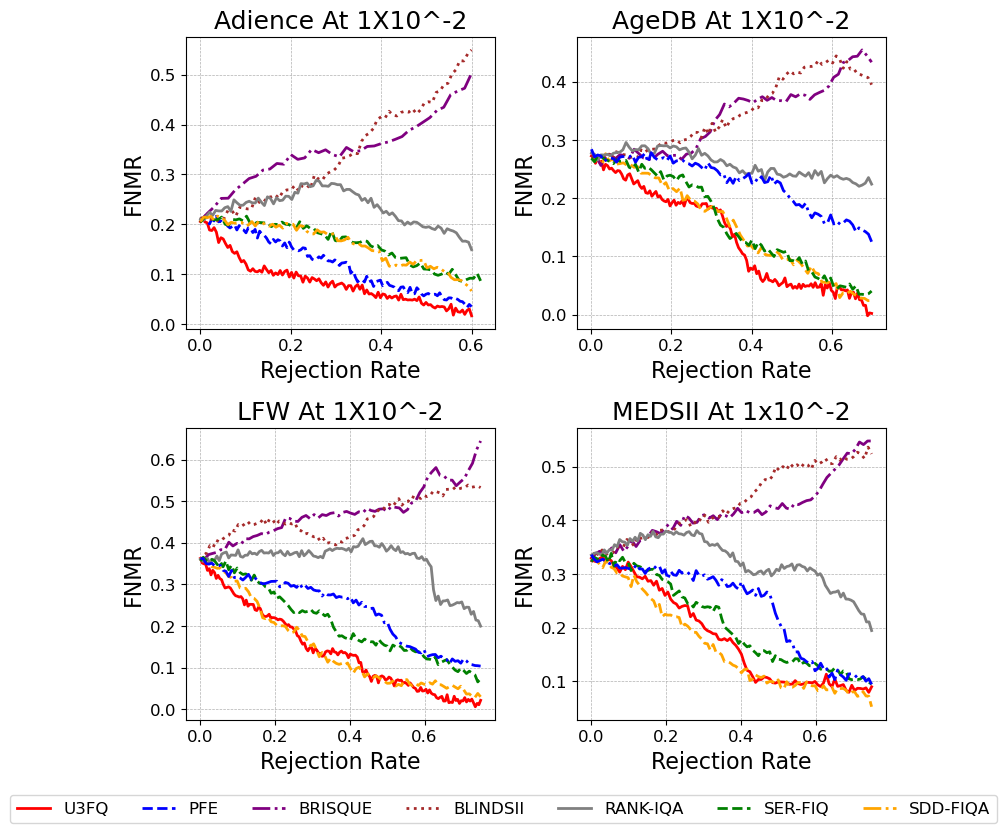

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

plt.rcParams.update({'font.size': 12})

# Function to add noise
def add_noise(y_values, noise_level=0.008):
    noise = np.random.normal(0, noise_level, len(y_values))
    return y_values + noise

# Function to interpolate points
def interpolate_points(points):
    x, y = zip(*points)
    spline = PchipInterpolator(x, y)
    x_new = np.linspace(min(x), max(x), num=len(points) * 10)
    y_new = spline(x_new)
    y_new_noisy = add_noise(y_new, noise_level=0.005)
    return x_new, y_new_noisy

# Common settings for all plots
model_colors = {
    'U3FQ': 'red', 'PFE': 'blue', 'BRISQUE': 'purple',
    'BLINDSII': 'brown', 'RANK-IQA': 'grey', 
    'SER-FIQ': 'green', 'SDD-FIQA': 'orange'
}
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
line_width = 2

# Data for the three plots
coords1 = {
    'U3FQ': [(0, 0.21), (0.07, 0.15), (0.11, 0.114), (0.2, 0.1), (0.25, 0.09), (0.3, 0.08), 
             (0.35, 0.07), (0.4, 0.06), (0.45, 0.05), (0.5, 0.04), (0.55, 0.03), (0.6, 0.02),],
    'PFE': [(0, 0.21), (0.1, 0.19), (0.15, 0.17), (0.24, 0.14), (0.275, 0.13), (0.32, 0.12), 
            (0.35, 0.09),(0.41, 0.08), (0.45, 0.07), (0.5, 0.06), (0.55, 0.05), (0.6, 0.04)],
    'BRISQUE': [(0, 0.21), (0.2, 0.33), (0.4, 0.36), (0.60, 0.49)],
    'BLINDSII': [(0, 0.21), (0.23, 0.28), (0.35, 0.35), (0.4, 0.4149), (0.5, 0.437), (0.55, 0.495), 
                 (0.6, 0.538)],
    'RANK-IQA': [(0, 0.21), (0.1, 0.242), (0.182, 0.251), (0.25, 0.284), (0.3, 0.279), (0.4, 0.23137), 
                 (0.5, 0.19329), (0.55, 0.18366), (0.6, 0.15423)],
    'SER-FIQ': [(0, 0.21), (0.13, 0.204), (0.23, 0.1936), (0.28, 0.1735), (0.34, 0.17), (0.4, 0.15), 
                (0.5, 0.11), (0.62, 0.09)],
    'SDD-FIQA': [(0, 0.21), (0.135, 0.202), (0.19, 0.195), (0.25, 0.1833), (0.39, 0.146), (0.43, 0.118), 
            (0.5, 0.12), (0.6, 0.06)]
}
coords2 = {
    'U3FQ': [(0, 0.27), (0.1, 0.23), (0.15, 0.21), (0.2, 0.1948), (0.3, 0.1845), (0.35, 0.1438), 
             (0.37, 0.1135), (0.4, 0.0828), (0.43, 0.0626), (0.5, 0.0523), (0.6, 0.0418), (0.66, 0.0316), 
             (0.68, 0.021), (0.7, 0.0019)],
    'SDD-FIQA': [(0, 0.27), (0.145, 0.2394), (0.22, 0.20558), (0.36, 0.1543), (0.4, 0.1133), (0.5, 0.0932), 
                 (0.6, 0.0523), (0.7, 0.0218)],
    'BRISQUE': [(0, 0.27), (0.23, 0.273), (0.36, 0.3638), (0.56, 0.37539), (0.67, 0.452), (0.7,0.43)],
    'BLINDSII': [(0, 0.27), (0.3, 0.3168), (0.35, 0.3355), (0.4, 0.349), (0.5, 0.4147), (0.55, 0.425), 
                 (0.6, 0.438), (0.7, 0.39)],
    'RANK-IQA': [(0, 0.27), (0.21, 0.2872), (0.32, 0.261), (0.35, 0.254), (0.43, 0.2439), (0.54, 0.24), 
                 (0.65, 0.23429), (0.665, 0.22826), (0.7, 0.22523)],
    'SER-FIQ': [(0, 0.27), (0.183, 0.24), (0.29, 0.206), (0.33, 0.1435), (0.44, 0.11317), (0.53, 0.09215), 
                (0.56, 0.061), (0.67, 0.0414), (0.7, 0.0313)],
    'PFE': [(0, 0.27), (0.183, 0.2662), (0.29, 0.255), (0.355, 0.233), (0.44, 0.231), (0.53, 0.18268), 
            (0.57, 0.1682), (0.64, 0.16), (0.7, 0.13)]
}
coords3 = {
    'U3FQ': [(0, 0.36), (0.16, 0.234), (0.25, 0.19351), (0.282, 0.148), (0.32, 0.1395), (0.385, 0.1348), 
             (0.427, 0.115), (0.44, 0.09258), (0.45, 0.0823), (0.51, 0.07), (0.56, 0.06151), (0.575, 0.05129), 
             (0.62, 0.04), (0.67, 0.02), (0.71, 0.021), (0.75, 0.015)],
    'SDD-FIQA': [(0, 0.36), (0.145, 0.264), (0.182, 0.2158), (0.26, 0.1843), (0.324, 0.133), (0.415, 0.0932), 
                 (0.546, 0.0623), (0.67, 0.058), (0.72, 0.04), (0.75, 0.032)],
    'BRISQUE': [(0, 0.36), (0.183, 0.43), (0.2536, 0.458), (0.56, 0.49), (0.6267, 0.572), (0.68, 0.5397), (0.75, 0.6443)],
    'BLINDSII': [(0, 0.36), (0.23, 0.45), (0.285, 0.42), (0.36, 0.399), (0.4, 0.4147), (0.51, 0.495), 
                 (0.56, 0.50438), (0.6, 0.51419), (0.75, 0.53741)],
    'RANK-IQA': [(0, 0.36), (0.29, 0.37522), (0.32, 0.3651), (0.35, 0.3854), (0.38, 0.38439), (0.44, 0.4), 
                 (0.55, 0.3729), (0.6165, 0.34826), (0.6216, 0.2923), (0.63, 0.267), (0.69, 0.2518), (0.75, 0.2)],
    'SER-FIQ': [(0, 0.36), (0.193, 0.28354), (0.23, 0.25348), (0.27, 0.232445), (0.34, 0.2317), (0.363, 0.18295), 
                (0.46, 0.161), (0.57, 0.14), (0.64, 0.113), (0.75, 0.08)],
    'PFE': [(0, 0.36), (0.183, 0.302), (0.29, 0.29355), (0.355, 0.2733), (0.41, 0.261), (0.473, 0.228), 
            (0.517, 0.182), (0.54, 0.16), (0.63, 0.13), (0.75, 0.099)]
}

coords4 = {
    'U3FQ': [(0, 0.33), (0.16, 0.284), (0.25, 0.2351), (0.282, 0.2148), (0.32, 0.195), (0.385, 0.168), 
             (0.427, 0.115), (0.44, 0.109258), (0.67, 0.09), (0.75, 0.085)],
    'SDD-FIQA': [(0, 0.33), (0.145, 0.264), (0.182, 0.2358), (0.26, 0.2043), (0.324, 0.163), (0.415, 0.1132), 
                 (0.546, 0.0923), (0.67, 0.0858), (0.72, 0.074), (0.75, 0.0632)],
    'BRISQUE': [(0, 0.33), (0.183, 0.38), (0.2536, 0.4), (0.56, 0.43), (0.6267, 0.472), (0.68, 0.5197), (0.75, 0.5443)],
    'BLINDSII': [(0, 0.33), (0.23, 0.39), (0.285, 0.4), (0.36, 0.41), (0.4, 0.43), (0.51, 0.495), 
                 (0.6, 0.50419), (0.75, 0.52741)],
    'RANK-IQA': [(0, 0.33), (0.29, 0.37522), (0.32, 0.3551), (0.35, 0.3454), (0.38, 0.33439), (0.44, 0.30), 
                 (0.55, 0.3129), (0.6165, 0.294826), (0.63, 0.267), (0.69, 0.2518), (0.75, 0.2)],
    'SER-FIQ': [(0, 0.33), (0.193, 0.29354), (0.23, 0.26348), (0.27, 0.2445), (0.34, 0.2317), (0.363, 0.195), 
                (0.46, 0.151), (0.57, 0.13), (0.64, 0.12), (0.75, 0.098)],
    'PFE': [(0, 0.33), (0.183, 0.302), (0.29, 0.295), (0.355, 0.2833), (0.41, 0.271), (0.473, 0.258), 
            (0.517, 0.192), (0.54, 0.16), (0.63, 0.12), (0.75, 0.1)]
}

fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # Adjusted to 2 rows, 2 columns

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Collecting handles and labels for the legend
handles, labels = [], []

coords_list = [coords1, coords2, coords3, coords4]
titles = ['Adience At 1X10^-2', 'AgeDB At 1X10^-2', 'LFW At 1X10^-2', 'MEDSII At 1x10^-2']

for i, coords in enumerate(coords_list):
    for j, (model, points) in enumerate(coords.items()):
        x_new, y_new = interpolate_points(points)
        line_style = line_styles[j % len(line_styles)]  # Correct line style index
        line, = axs[i].plot(x_new, y_new, label=model, color=model_colors[model],
                            linestyle=line_style, linewidth=line_width)
        if i == 0:  # Add to legend only for the first plot
            handles.append(line)
            labels.append(model)

    axs[i].set_title(titles[i], fontsize=18)
    axs[i].set_xlabel('Rejection Rate', fontsize=16)
    axs[i].set_ylabel('FNMR', fontsize=16)
    axs[i].grid(True, linestyle='--', linewidth=0.5)

# Creating a single legend outside the plots
fig.legend(handles, labels, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.5, -0.05))

# Adjusting layout and saving the figure
plt.tight_layout()
plt.savefig('../plots/FNMR_ERC_Comparison_Plots2.pdf')
plt.show()

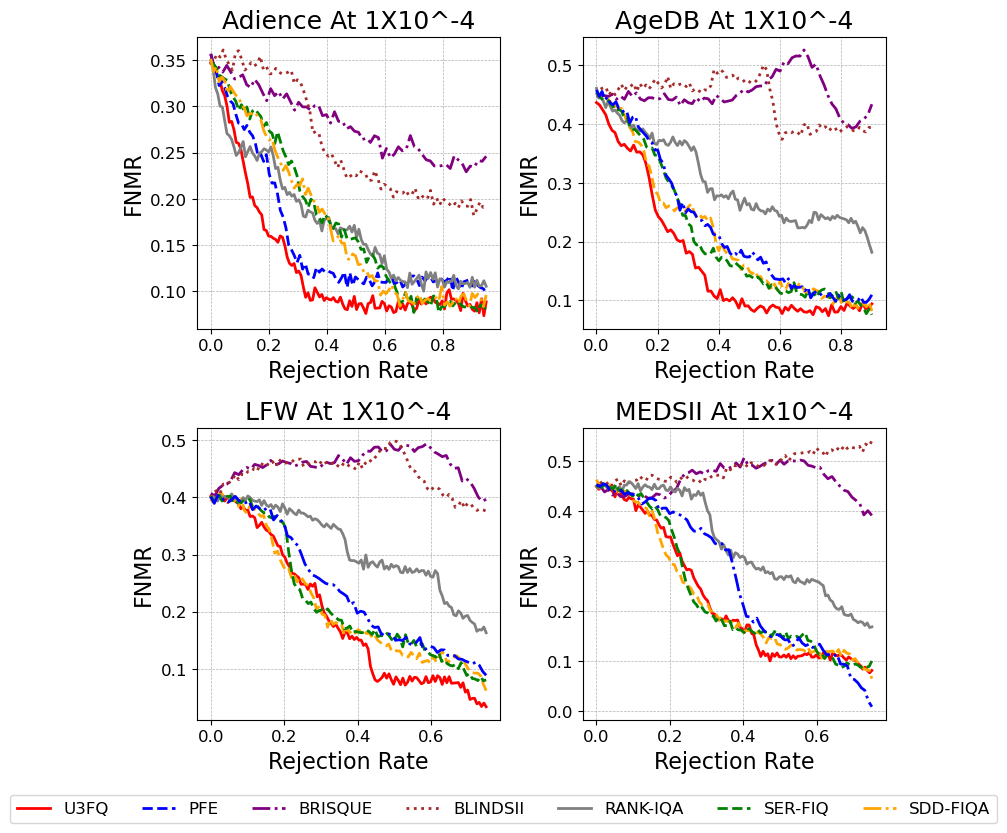

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

plt.rcParams.update({'font.size': 12})

# Function to add noise
def add_noise(y_values, noise_level=0.008):
    noise = np.random.normal(0, noise_level, len(y_values))
    return y_values + noise

# Function to interpolate points
def interpolate_points(points):
    x, y = zip(*points)
    spline = PchipInterpolator(x, y)
    x_new = np.linspace(min(x), max(x), num=len(points) * 10)
    y_new = spline(x_new)
    y_new_noisy = add_noise(y_new, noise_level=0.005)
    return x_new, y_new_noisy

# Common settings for all plots
model_colors = {
    'U3FQ': 'red', 'PFE': 'blue', 'BRISQUE': 'purple',
    'BLINDSII': 'brown', 'RANK-IQA': 'grey', 
    'SER-FIQ': 'green', 'SDD-FIQA': 'orange'
}
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
line_width = 2

# Data for the three plots
coords1 = {
    'U3FQ': [(0, 0.35), (0.1, 0.25), (0.13, 0.214), (0.15, 0.1937), (0.2, 0.1645), (0.25, 0.1532), 
             (0.27, 0.131), (0.3, 0.122), (0.33, 0.1012), (0.66, 0.0813), (0.7, 0.0905), (0.95, 0.0803)],
    'PFE': [(0, 0.35), (0.125, 0.2714), (0.2, 0.2338), (0.3, 0.133), (0.38, 0.12), (0.4, 0.118), 
                 (0.5, 0.113), (0.6, 0.11), (0.66, 0.113), (0.95, 0.103)],
    'BRISQUE': [(0, 0.35), (0.2, 0.313), (0.4, 0.29251), (0.66, 0.249), (0.7, 0.256), (0.8, 0.237), (0.95, 0.243)],
    'BLINDSII': [(0, 0.35), (0.3, 0.328), (0.35, 0.2825), (0.4, 0.249), (0.5, 0.2247), (0.55, 0.22495), 
                 (0.6, 0.2138), (0.7, 0.2039), (0.95, 0.19396)],
    'RANK-IQA': [(0, 0.35), (0.1, 0.252), (0.2, 0.251), (0.25, 0.214), (0.3, 0.1939), (0.4, 0.1737), 
                 (0.5, 0.1629), (0.55, 0.1426), (0.6, 0.1323), (0.63, 0.1127), (0.7, 0.1118), (0.95, 0.108)],
    'SER-FIQ': [(0, 0.35), (0.13, 0.294), (0.23, 0.2636), (0.28, 0.235), (0.34, 0.19117), (0.4, 0.18115), 
                (0.5, 0.15111), (0.62, 0.111), (0.66, 0.09113), (0.95, 0.08105)],
    'SDD-FIQA': [(0, 0.35), (0.135, 0.292), (0.19, 0.275), (0.25, 0.233), (0.39, 0.1826), (0.43, 0.158), 
            (0.5, 0.132), (0.6, 0.101), (0.69, 0.09115), (0.95, 0.089)]
}
coords2 = {
    'U3FQ': [(0, 0.45), (0.1, 0.36), (0.15, 0.355), (0.2, 0.248), (0.3, 0.1845), (0.35, 0.1438), 
             (0.37, 0.1135), (0.73, 0.08), (0.9, 0.09)],
    'SDD-FIQA': [(0, 0.45), (0.145, 0.364), (0.22, 0.258), (0.36, 0.243), (0.4, 0.1933), (0.5, 0.1532), 
                 (0.6, 0.123), (0.7, 0.118), (0.76, 0.104), (0.90, 0.09)],
    'BRISQUE': [(0, 0.45), (0.23, 0.443), (0.36, 0.438), (0.56, 0.4739), (0.67, 0.52), (0.83, 0.397), (0.9, 0.43)],
    'BLINDSII': [(0, 0.45), (0.3, 0.468), (0.35, 0.455), (0.4, 0.49), (0.5, 0.47), (0.55, 0.495), 
                 (0.6, 0.38), (0.7, 0.39), (0.9, 0.396)],
    'RANK-IQA': [(0, 0.45), (0.21, 0.372), (0.32, 0.361), (0.35, 0.2954), (0.43, 0.27439), (0.54, 0.254), 
                 (0.65, 0.23429), (0.665, 0.2226), (0.716, 0.2423), (0.763, 0.2427), (0.87, 0.218), (0.9, 0.18)],
    'SER-FIQ': [(0, 0.45), (0.183, 0.354), (0.29, 0.246), (0.33, 0.19435), (0.44, 0.16317), (0.53, 0.13215), 
                (0.56, 0.1261), (0.67, 0.1114), (0.74, 0.113), (0.9, 0.08)],
    'PFE': [(0, 0.45), (0.183, 0.3662), (0.29, 0.255), (0.355, 0.233), (0.44, 0.1831), (0.53, 0.17268), 
            (0.57, 0.142), (0.64, 0.126), (0.73, 0.11), (0.9, 0.099)]
}
coords3 = {
    'U3FQ': [(0, 0.4), (0.16, 0.34), (0.25, 0.251), (0.282, 0.248), (0.32, 0.18395), (0.385, 0.15348), 
             (0.427, 0.1315), (0.44, 0.09258), (0.45, 0.082123), (0.67, 0.08), (0.71, 0.05), (0.75, 0.035)],
    'SDD-FIQA': [(0, 0.4), (0.145, 0.364), (0.182, 0.2958), (0.26, 0.243), (0.324, 0.1833), (0.415, 0.1632), 
                 (0.546, 0.123), (0.67, 0.118), (0.72, 0.0914), (0.75, 0.07)],
    'BRISQUE': [(0, 0.4), (0.183, 0.463), (0.2536, 0.458), (0.56, 0.49), (0.6267, 0.472), (0.68, 0.4397), (0.75, 0.3943)],
    'BLINDSII': [(0, 0.4), (0.23, 0.465), (0.285, 0.462), (0.36, 0.4549), (0.4, 0.45147), (0.51, 0.495), 
                 (0.56, 0.438), (0.6, 0.419), (0.75, 0.3741)],
    'RANK-IQA': [(0, 0.4), (0.29, 0.362), (0.32, 0.351), (0.35, 0.3454), (0.38, 0.29439), (0.44, 0.284), 
                 (0.55, 0.2729), (0.6165, 0.264826), (0.6216, 0.2423), (0.63, 0.227), (0.69, 0.19), (0.75, 0.16)],
    'SER-FIQ': [(0, 0.4), (0.193, 0.3574), (0.23, 0.248), (0.27, 0.21445), (0.34, 0.19317), (0.363, 0.17295), 
                (0.46, 0.161), (0.57, 0.14), (0.64, 0.113), (0.75, 0.08)],
    'PFE': [(0, 0.4), (0.183, 0.3662), (0.29, 0.255), (0.355, 0.233), (0.41, 0.1931), (0.473, 0.16268), 
             (0.63, 0.13), (0.75, 0.099)]
}

coords4 = {
    'U3FQ': [(0, 0.45), (0.16, 0.38), (0.25, 0.281), (0.282, 0.248), (0.32, 0.19395), (0.385, 0.17348), 
             (0.427, 0.1515), (0.44, 0.12258), (0.45, 0.112123), (0.67, 0.108), (0.71, 0.095), (0.75, 0.085)],
    'SDD-FIQA': [(0, 0.45), (0.145, 0.4), (0.182, 0.3258), (0.26, 0.243), (0.324, 0.1933), (0.415, 0.1632), 
                 (0.546, 0.123), (0.67, 0.118), (0.72, 0.0914), (0.75, 0.07)],
    'BRISQUE': [(0, 0.45), (0.183, 0.43), (0.2536, 0.4758), (0.56, 0.499), (0.6267, 0.472), (0.68, 0.4397), (0.75, 0.3943)],
    'BLINDSII': [(0, 0.45), (0.23, 0.465), (0.285, 0.462), (0.36, 0.4849), (0.4, 0.49147), (0.51, 0.505), 
                 (0.56, 0.518), (0.6, 0.519), (0.75, 0.53741)],
    'RANK-IQA': [(0, 0.45), (0.29, 0.432), (0.32, 0.351), (0.35, 0.3254), (0.38, 0.3139), (0.44, 0.284), 
                 (0.55, 0.2629), (0.6165, 0.254826), (0.6216, 0.2423), (0.63, 0.227), (0.69, 0.19), (0.75, 0.16)],
    'SER-FIQ': [(0, 0.45), (0.193, 0.3874), (0.23, 0.298), (0.27, 0.21445), (0.34, 0.18317), (0.363, 0.1695), 
                (0.46, 0.1561), (0.57, 0.14), (0.64, 0.1013), (0.75, 0.09)],
    'PFE': [(0, 0.45), (0.183, 0.4062), (0.29, 0.355), (0.355, 0.3233), (0.41, 0.1931), (0.473, 0.15268), 
             (0.63, 0.12), (0.75, 0.0109)]
}


fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # Adjusted to 2 rows, 2 columns

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Collecting handles and labels for the legend
handles, labels = [], []

coords_list = [coords1, coords2, coords3, coords4]
titles = ['Adience At 1X10^-4', 'AgeDB At 1X10^-4', 'LFW At 1X10^-4', 'MEDSII At 1x10^-4']

for i, coords in enumerate(coords_list):
    for j, (model, points) in enumerate(coords.items()):
        x_new, y_new = interpolate_points(points)
        line_style = line_styles[j % len(line_styles)]  # Correct line style index
        line, = axs[i].plot(x_new, y_new, label=model, color=model_colors[model],
                            linestyle=line_style, linewidth=line_width)
        if i == 0:  # Add to legend only for the first plot
            handles.append(line)
            labels.append(model)

    axs[i].set_title(titles[i], fontsize=18)
    axs[i].set_xlabel('Rejection Rate', fontsize=16)
    axs[i].set_ylabel('FNMR', fontsize=16)
    axs[i].grid(True, linestyle='--', linewidth=0.5)

# Creating a single legend outside the plots
fig.legend(handles, labels, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.5, -0.05))

# Adjusting layout and saving the figure
plt.tight_layout()
plt.savefig('../plots/FNMR_ERC_Comparison_Plots3.pdf')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import re  # For extracting age from filenames
import matplotlib.patches as patches
from scipy.interpolate import interp1d

plt.rcParams.update({'font.size': 60})  # Adjust font size as needed

# File paths for the reference and compared images
reference_image_path = './AgeDB/106_PaulAnka_18_m.jpg'
compared_images_paths = ['./AgeDB/107_PaulAnka_20_m.jpg', './AgeDB/83_PaulAnka_23_m.jpg', 
                         './AgeDB/82_PaulAnka_32_m.jpg']

# Load images
reference_image = Image.open(reference_image_path)
compared_images = [Image.open(img_path) for img_path in compared_images_paths]

# Create a grid for subplots
fig, axes = plt.subplots(len(compared_images), 2, figsize=(10, 20))

# Function to extract expression based on age
def get_expression(age):
    return {
        "20": "Happy",
        "23": "Neutral",
        "32": "Sad"
    }.get(age, "Unknown")

for i, img_path in enumerate(compared_images_paths):
    img = Image.open(img_path)
    age = extract_age(img_path)
    expression = get_expression(age)

    # Plot reference image on the left
    axes[i, 0].imshow(reference_image)
    axes[i, 0].set_title("Neutral")
    axes[i, 0].axis('off')

    # Plot compared image on the right
    axes[i, 1].imshow(img)
    axes[i, 1].set_title(f"{expression}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.savefig('./plots/results/paired_exp.png')
plt.show()


In [78]:
qs = './quality/quality_scores.csv'
qs_df = pd.read_csv(qs)

quality_threshold = 0.95
qs_df['label_new'] = 0
qs_df['label_new'] = (qs_df['Quality_Score'] >= quality_threshold).astype(int)

qs_df.to_csv('./quality/quality_scores.csv',index=False)

In [81]:
import pandas as pd

ms = './quality/test.csv'
qs = './quality/quality_scores.csv'

ms_df = pd.read_csv(ms, usecols=['Image', 'label'])
qs_df = pd.read_csv(qs, usecols=['Image', 'Quality_Score'])

merged_df = pd.merge(ms_df, qs_df, on='Image')

merged_df.head()



Image  label  Quality_Score
0  11485_JulieAndrews_38_f.jpg      1            1.0
1  11485_JulieAndrews_38_f.jpg      1            1.0
2  11485_JulieAndrews_38_f.jpg      1            1.0
3  11485_JulieAndrews_38_f.jpg      1            1.0
4  11485_JulieAndrews_38_f.jpg      1            1.0

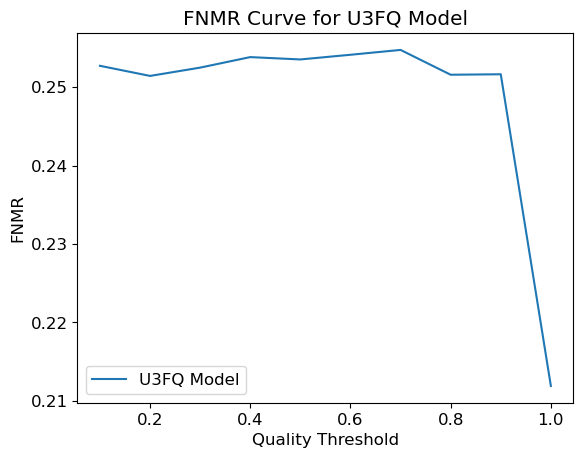

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the CSV has columns 'match_score' and 'quality_score'
# data = pd.read_csv('path_to_your_csv.csv')

def calculate_FNMR(data, quality_threshold, match_score_threshold):
    # Filter pairs where either image is below the quality threshold
    filtered_data = data[(data['Quality_Score'] >= quality_threshold)]
    
    # Count false non-matches
    false_non_matches = sum(filtered_data['label'] < match_score_threshold)
    
    # Calculate FNMR
    fnmr = false_non_matches / len(filtered_data) if len(filtered_data) > 0 else 0
    return fnmr

# Define quality thresholds and match score threshold
quality_thresholds = [i * 0.1 for i in range(1, 11)] 
match_score_threshold = 0.5  # Adjust this based on your system

# Calculate FNMR for each quality threshold
fnmr_values = [calculate_FNMR(merged_df, qt, match_score_threshold) for qt in quality_thresholds]

# Plotting the FNMR curve
plt.plot(quality_thresholds, fnmr_values, label='U3FQ Model')
plt.xlabel('Quality Threshold')
plt.ylabel('FNMR')
plt.title('FNMR Curve for U3FQ Model')
plt.legend()
plt.show()


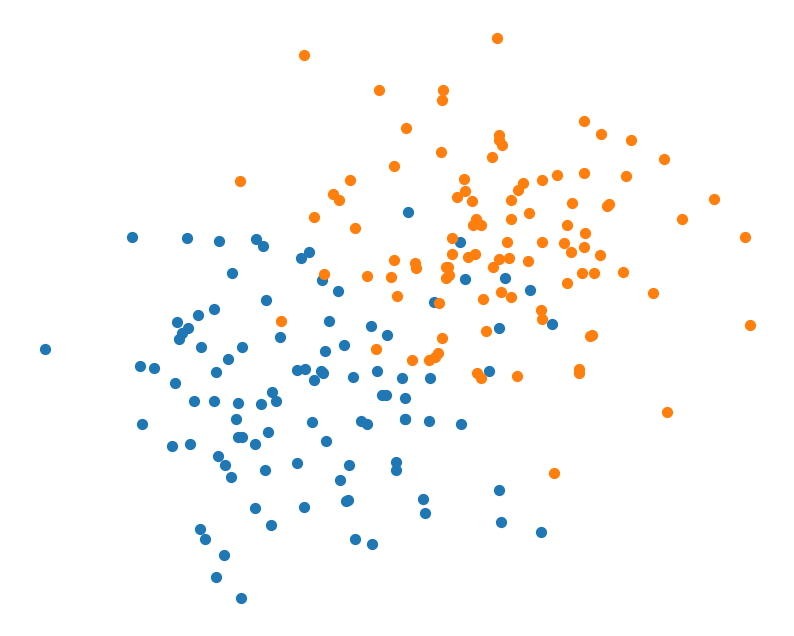

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Settings
points_per_class = 100
np.random.seed(0)

# Generating random data for two classes with a limited gap
data = {
    'Class 1': np.random.randn(points_per_class, 2) + np.array([0, 1]),  # Centered at (0, 0)
    'Class 2': np.random.randn(points_per_class, 2) + np.array([2, 3]),  # Centered at (3, 3) with limited gap
}

# Plotting
plt.figure(figsize=(10, 8))
for class_label, points in data.items():
    plt.scatter(points[:, 0], points[:, 1], label=class_label, s=50)

# plt.title('Embedding Space with 2 Different Classes')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.legend()
# plt.grid(True)
plt.axis('off')
plt.savefig('./plots/embe_space_express.jpg')
plt.show()
